
# Avocado Price Prediction - Modelling and Visualisations


#### THIS NOTEBOOK WAS MOSTLY DEVELOPED IN VSCODE.  IN TESTING IT HAS BEEN IDENTIFIED THAT PLOTLY CAN CRASH IN COLAB. RESTARTING THE BROWSER SESSION SEEMS TO FIX THIS

## Aims

The aim of this notebook is to attempt demostrated the ablity to forecast average prices of Avocados of a particular 'type' (either Organic or Conventional) and from a particular region.  The prediction will be based on historic sales data.

Historic data could be input to the model which would use the data to produce a plot of future prices to bussiness users plan.

To test the predictions portion of the data will be held back and used to test the model.

Due to the amount of data available, the predictions will be be made for 2 months into the future.  This will allow for testing and validation of the predictions whilst still allowing for sufficient training data.

Plan


*   Import and Inspect Data
*   Data Quaility Checks
*   Train/Validate/Test split
*   EDA
*   Feature Creation
*   Model Seleciton and Processing
*   Conclusion
*   Biblography






In [2]:
## install python packages
# List of dependencies
dependencies = [
    'pandas',
    'tabulate',
    'numpy',
    'scikit-learn',
    'dash',
    'plotly',
    'ipykernel',
    'prophet',
    'seaborn',
    'xgboost',
    'nbformat',
    # 'ydata-profiling',
    'joblib'
]

# Loop through the list and install each dependency
for package in dependencies:
    !pip install {package} -q


In [73]:
# import libraries
import pandas as pd # used to import and manipulate data
import pprint as pp # used to print arrays and dicts in a user readable format
from tabulate import tabulate # create tables when outputting to the console
import numpy as np # used for numerical computations and array operations
import copy # used for created copies of objects

from scipy import stats  # For z-score outlier detection
import matplotlib.pyplot as plt # used for plotting charts
import seaborn as sns # used for plotting charts

import plotly.graph_objects as go
import plotly.express as px
import dash
from dash import dcc
from dash import html
from dash.dependencies import Input, Output

from sklearn.preprocessing import StandardScaler # used to scale numerical continuous variables
from sklearn.model_selection import train_test_split # used to split data into training and testing sets
from sklearn.ensemble import RandomForestRegressor # used for random forest regression
from sklearn.metrics import mean_squared_error, r2_score # used to evaluate model performance
from sklearn.preprocessing import OneHotEncoder # used to encode categorical variables
from sklearn.compose import ColumnTransformer # used to combine OneHotEncoder and StandardScaler
from sklearn.model_selection import TimeSeriesSplit # used to split data for time series cross-validation
from sklearn.model_selection import GridSearchCV # used to perform grid search for hyperparameter tuning
from sklearn.feature_selection import SelectKBest, f_regression # used to select top features
from sklearn.model_selection import ParameterGrid # used to generate parameter grids for hyperparameter tuning

from xgboost import XGBRegressor # used for gradient boosting

# set the format of the columns to prevent exponents in the dataframe table print outs
pd.set_option('display.float_format', '{:.2f}'.format)

## Import and Inspect Data


#### Import the data
The data will be imported to a DataFrame using pd.read_csv.

After import column names will be reformatted and types converted.

Functions will be using to analyse the DataFrame's values.

In [74]:
# import the data

# UPDATE THIS VARIABLE TO POINT TO THE LOCATION OF YOUR DATA:
data_file_and_path = 'avocado_data.csv'

avocado_data = pd.read_csv(data_file_and_path)

In [75]:
avocado_data # print the data

,Unnamed: 0,Date,AveragePrice,Total Volume,Type PLU4046,Type PLU4225,Type PLU4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,0,27/12/2015,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.00,conventional,2015,Albany
1,1,20/12/2015,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.00,conventional,2015,Albany
2,2,13/12/2015,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.00,conventional,2015,Albany
3,3,06/12/2015,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.00,conventional,2015,Albany
4,4,29/11/2015,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.00,conventional,2015,Albany
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18244,7,04/02/2018,1.63,17074.83,2046.96,1529.20,0.00,13498.67,13066.82,431.85,0.00,organic,2018,WestTexNewMexico
18245,8,28/01/2018,1.71,13888.04,1191.70,3431.50,0.00,9264.84,8940.04,324.80,0.00,organic,2018,WestTexNewMexico
18246,9,21/01/2018,1.87,13766.76,1191.92,2452.79,727.94,9394.11,9351.80,42.31,0.00,organic,2018,WestTexNewMexico
18247,10,14/01/2018,1.93,16205.22,1527.63,2981.04,727.01,10969.54,10919.54,50.00,0.00,organic,2018,WestTexNewMexico


In [76]:
# according to the brief the data has 18,250 instances and 14 columns
# (it looks like it is 18,249 plus a header row)
avocado_data.shape

(18249, 14)

#### Rename Columns Headings


In [77]:
# standardise the columns and rename them to make them easier to work with

avocado_data.drop('Unnamed: 0', axis=1, inplace=True) # drop the unnamed column
avocado_data.rename(columns={'AveragePrice': 'average_price'}, inplace=True) # fix case and standardise the column

# convert to lower case and replace spaces with _
avocado_data.columns = [col.lower().replace(' ', '_') for col in avocado_data.columns]

avocado_data.columns




Index(['date', 'average_price', 'total_volume', 'type_plu4046', 'type_plu4225',
       'type_plu4770', 'total_bags', 'small_bags', 'large_bags', 'xlarge_bags',
       'type', 'year', 'region'],
      dtype='object')

#### Check the Data Values

In [78]:


# describe the data
avocado_data.describe().T

,count,mean,std,min,25%,50%,75%,max
average_price,18249.00,1.41,0.40,0.44,1.10,1.37,1.66,3.25
total_volume,18249.00,850644.01,3453545.36,84.56,10838.58,107376.76,432962.29,62505646.52
type_plu4046,18249.00,293008.42,1264989.08,0.00,854.07,8645.30,111020.20,22743616.17
type_plu4225,18249.00,295154.57,1204120.40,0.00,3008.78,29061.02,150206.86,20470572.61
type_plu4770,18249.00,22839.74,107464.07,0.00,0.00,184.99,6243.42,2546439.11
total_bags,18249.00,239639.20,986242.40,0.00,5088.64,39743.83,110783.37,19373134.37
small_bags,18249.00,182194.69,746178.51,0.00,2849.42,26362.82,83337.67,13384586.80
large_bags,18249.00,54338.09,243965.96,0.00,127.47,2647.71,22029.25,5719096.61
xlarge_bags,18249.00,3106.43,17692.89,0.00,0.00,0.00,132.50,551693.65
year,18249.00,2016.15,0.94,2015.00,2015.00,2016.00,2017.00,2018.00


- The output above shows that although the price does not seem to fluctuate too much with standard deviation of 0.40, the total volume of does.
- Quite a few of the columns have 0 as a value
- The dataset covers 2015-2018


## Data Quality Checks

In [79]:


# A function has been created to check the DataFrames
#  Previously used in PDfA assignment (Glover, 2024):

def analyze_dataframe(df: pd.DataFrame,
                      columns_to_check: list=None,
                      dupe_columns_check: list=None
                      )->None:
    """Review the values in a DataFrame checking:

    * For missing/null values in the DataFrame
    * For each column print the values and counts of values if the number of
        distinct values is less than 5
    * If the number of distinct values is greater than 5 print the
        min/max/average (if possible)

    Args:
        df (pd.DataFrame): DataFrame to analyze
        columns_to_check (list): If required, a list of columns in the
            DataFrame can be specified. Defaults to None, which means all
            columns will be analyzed
        dupe_columns_check (list): Check specific columns for duplicates,
        Defaults to None (meaning no columns will be checked)
    """


    if columns_to_check != None:
        # if columns to check is passed in create a specific list
        columns_list = columns_to_check
    else:
        # otherwise check all columns
        columns_list = df.columns


    # check for null or missing values
    null_columns = df.columns[df.isnull().any()]
    if len(null_columns) > 0:
        print("*  The following columns have null or missing values:")
        for col in null_columns:
            if col in columns_list:
                print(f"    - {col}")
    else:
        print("* There are no null or missing values in the DataFrame.")
        print()


    # check for duplicate rows
    if df.duplicated().any():
        print("*  Duplicates rows found in the DataFrame.")
    else:
        print("*  No duplicate rows found in the DataFrame")

    # check specific_columns for dupes
    if dupe_columns_check != None:
        for col in dupe_columns_check:
            if df.duplicated(subset=[col]).any():
                print(f"*  Duplicates found in the {col} column.")
            else:
                print(f"*  No duplicates found in the {col} column")


    # create a list to store table data
    table_data = []


    # iterate over columns
    for column in columns_list:
        try:
            unique_values = df[column].value_counts()
            num_unique_values = len(unique_values)
        except ValueError:
            unique_values = {'error': 0}
            num_unique_values = 0

        column_info = []

        column_info.append(f"{column}")

        # check number of distinct values
        if num_unique_values > 5:
            # add summary statistics to the table data
            column_info.append(f"NDV: {num_unique_values}, (greater than 5)")

            try:
                column_info.append(f"Min: {df[column].min()}")
            except TypeError:
                column_info.append("Min: Cannot Calculate due to Type")

            try:
                column_info.append(f"Max: {df[column].max()}")
            except TypeError:
                column_info.append("Max: Cannot Calculate due to Type")

            try:
                column_info.append(f"Avg: {df[column].mean()}")
            except TypeError:
                column_info.append("Avg: Cannot Calculate due to Type")
        else:

        # add distinct values and counts to the table data
            column_info.append("Counts by value:")
            for value, count in unique_values.items():
                column_info.append(f"{value}: {count}")


        table_data.append(column_info)
    print()
    print('NDV : Number of distinct Values')
    print('If NDV > 5 values will not be printed')
    print()
    # print the table
    print(tabulate(table_data, headers=['Column', '', '', '', '', '', '', ''],
                   tablefmt='github'))



#### Check the Data Types

In [80]:
avocado_data.dtypes # print the data types of the dataframe

,0
date,object
average_price,float64
total_volume,float64
type_plu4046,float64
type_plu4225,float64
type_plu4770,float64
total_bags,float64
small_bags,float64
large_bags,float64
xlarge_bags,float64


Looking at the data certain columns need to have the data types updated for future processing

In [81]:
def reformat_dataframe_dtypes(df: pd.DataFrame, target_formats:dict, day_first:bool=True):
  """
  Reformats columns in a DataFrame based on a dictionary of target datatypes.

  Args:
    df: The DataFrame to reformat.
    target_formats: A dictionary where keys are column names and values are target data types.
                    Supported types: 'date', 'string', 'int', 'float'.
    day_first: (default value = True) Specify the date in the format day-month-year(True)
                as opposed to month-day-year(False).

  Returns:
    The reformatted DataFrame.
  """

  target_formats_length = len(target_formats)
  df_num_columns = len(df.columns)

  if target_formats_length != df_num_columns:
    raise Exception((f"""Length of the target formats ({target_formats_length}) does not
                     match the number of columns in the DataFrame ({df_num_columns})."""))

  for col, target_type in target_formats.items():
    if target_type == 'date':
      try:
        df[col] = pd.to_datetime(df[col], dayfirst=day_first)
      except ValueError:
        print(f"Error converting column '{col}' to date. Check data format.")
    elif target_type == 'string':
      df[col] = df[col].astype('string')
    elif target_type == 'int':
      try:
        df[col] = pd.to_numeric(df[col], errors='coerce').astype(int)
      except ValueError:
        print(f"Error converting column '{col}' to integer. Check data format.")
    elif target_type == 'float':
      try:
        df[col] = pd.to_numeric(df[col], errors='coerce').astype(float)
      except ValueError:
        print(f"Error converting column '{col}' to float. Check data format.")
    else:
      print(f"Unsupported target type: '{target_type}' for column '{col}'")

  return df

In [82]:
# create a dict to hold the columns and target formats
DESIRED_FORMATS = {
    'date': 'date',
    'average_price': 'float',
    'total_volume': 'float',
    'type_plu4046': 'float',
    'type_plu4225': 'float',
    'type_plu4770': 'float',
    'total_bags': 'float',
    'small_bags': 'float',
    'large_bags': 'float',
    'xlarge_bags': 'float',
    'type': 'string',
    'year': 'int',
    'region': 'string',
}

In [83]:
# reformat the columns and print the formats
avocado_data_dtypes = reformat_dataframe_dtypes(avocado_data.copy(), DESIRED_FORMATS)
avocado_data_dtypes.dtypes

,0
date,datetime64[ns]
average_price,float64
total_volume,float64
type_plu4046,float64
type_plu4225,float64
type_plu4770,float64
total_bags,float64
small_bags,float64
large_bags,float64
xlarge_bags,float64


In [84]:
analyze_dataframe(avocado_data)

* There are no null or missing values in the DataFrame.

*  No duplicate rows found in the DataFrame

NDV : Number of distinct Values
If NDV > 5 values will not be printed

| Column        |                              |                    |                       |                                   |            |
|---------------|------------------------------|--------------------|-----------------------|-----------------------------------|------------|
| date          | NDV: 169, (greater than 5)   | Min: 01/01/2017    | Max: 31/12/2017       | Avg: Cannot Calculate due to Type |            |
| average_price | NDV: 259, (greater than 5)   | Min: 0.44          | Max: 3.25             | Avg: 1.405978409775878            |            |
| total_volume  | NDV: 18237, (greater than 5) | Min: 84.56         | Max: 62505646.52      | Avg: 850644.0130089321            |            |
| type_plu4046  | NDV: 17702, (greater than 5) | Min: 0.0           | Max: 22743616.17      | Avg: 293008.424530

Calculating the Min Max on the dates stored as text returns incorrect values.

In [85]:
analyze_dataframe(avocado_data_dtypes)

* There are no null or missing values in the DataFrame.

*  No duplicate rows found in the DataFrame

NDV : Number of distinct Values
If NDV > 5 values will not be printed

| Column        |                              |                          |                          |                                    |            |
|---------------|------------------------------|--------------------------|--------------------------|------------------------------------|------------|
| date          | NDV: 169, (greater than 5)   | Min: 2015-01-04 00:00:00 | Max: 2018-03-25 00:00:00 | Avg: 2016-08-13 23:30:43.498273792 |            |
| average_price | NDV: 259, (greater than 5)   | Min: 0.44                | Max: 3.25                | Avg: 1.405978409775878             |            |
| total_volume  | NDV: 18237, (greater than 5) | Min: 84.56               | Max: 62505646.52         | Avg: 850644.0130089321             |            |
| type_plu4046  | NDV: 17702, (greater than 5) | Min: 0.0     

With the dates reformatted the correct min and max values are returned.

In [86]:
# Additional Check for Null Values:

print('Null Values in Avocado DateFrame')
print(avocado_data_dtypes.isnull().sum())

Null Values in Avocado DateFrame
date             0
average_price    0
total_volume     0
type_plu4046     0
type_plu4225     0
type_plu4770     0
total_bags       0
small_bags       0
large_bags       0
xlarge_bags      0
type             0
year             0
region           0
dtype: int64


The dataset looks fairly complete with no null or missing values.

Additional checks will carried out to count the number on observations for the type and region columns when compared to the dates.

In [87]:
# return the min and the max number of records for each region and type combination
# pd.set_option('display.max_rows', None)  # display all row in the dataframe
check_completeness = avocado_data.groupby(['region', 'type'])['date'].agg(['count']).reset_index()

# pivot the dataframe
df_pivot = check_completeness.pivot(index='region', columns='type', values='count')


# create a heatmap using plotly
fig = go.Figure(data=go.Heatmap(
                   z=df_pivot.values,
                   x=df_pivot.columns,
                   y=df_pivot.index,
                   colorscale='Viridis',
                   colorbar=dict(title='Record Count')
))

# add titles and adjust size
fig.update_layout(
    title='Record Counts by Region and Type',
    xaxis_title='Type',
    yaxis_title='Region',
    xaxis=dict(tickmode='linear'),
    yaxis=dict(tickmode='linear'),
    width=500,
    height=1000,
)

fig.show()

- THe Heatmap above shows that most regions & type combinations have 169 records, apart from region:WestTexNewMexico and type:organic that seems to be missing data for 3 weeks, with 166 records.
- Synthetic records could be imputed to fill in the missing times series data if required.
- Also the TotalUS region can be seen in this table.  This would explain the large variation in total bags sold
- There are Regions that seem to be 'States' or 'areas' e.g. California, NorthEast which would encompass other regions.
  - As the calculations will be made at the region and type level leaving this in should not cause any issues.


In [88]:
# avocado_data_regions is the DataFrame that will be used in the rest of the processing
avocado_data_regions = avocado_data_dtypes.copy()
# avocado_data_regions = avocado_data_dtypes.query('region != "TotalUS"')
# avocado_data_total_us = avocado_data_dtypes.query('region == "TotalUS"')
# avocado_data_total_us



## 6. Test/Train Split

When training and testing a model on time series data the normal practice is to hold out a section of the data to use for validation.  Normally this is 20% or at least enough data to cover period for which you want to forecast (Hyndman and Athanasopoulos, 2021).

The dates in the dataset look like they are at weekly intervals and in dataset there are 169 dates.  For proper training, validation and testing and to help avoid over-fitting the data will be split into 3 datasets.

In the feature creation stage, lagged features will be created for 8 weeks to help train the model.  That will mean that the first 8 weeks of data will be dropped as the will not have data available to create the features.

The data will be split roughly in 60/20/20, with allowances made in the training set losing records.

As predictions are for 8 weeks into the future, this will give a reasonable size for validate and test sets.  The dataset will be split on time, rather than by a random split, to prevent the model 'seeing the future' (Nielsen, 2019b).

EDA will be carried out on the training data only.

In [89]:
# get the minimum and maximum dates from the dataset
check_dates = avocado_data_regions['date'].agg(['min', 'max']).reset_index()
check_dates

,index,date
0,min,2015-01-04
1,max,2018-03-25


In [90]:

# calculate the split dates
split_date_test = pd.to_datetime('2018-03-25') - pd.DateOffset(weeks=41)
split_date_val = pd.to_datetime('2018-03-25') - pd.DateOffset(weeks=20)
# create the training, validation, and testing datasets
train_data = avocado_data_regions[avocado_data_regions['date'] < split_date_test]
val_data = avocado_data_regions[(avocado_data_regions['date'] >= split_date_test) & (avocado_data_regions['date'] < split_date_val)]
test_data = avocado_data_regions[avocado_data_regions['date'] >= split_date_val]

# check the split:
num_distinct_dates_train = len(train_data['date'].unique())
num_distinct_dates_val = len(val_data['date'].unique())
num_distinct_dates_test = len(test_data['date'].unique())

print(f"Number of distinct dates in the train dataset: {num_distinct_dates_train}")
print(f"Number of distinct dates in the validation dataset: {num_distinct_dates_val}")
print(f"Number of distinct dates in the test dataset: {num_distinct_dates_test}")



Number of distinct dates in the train dataset: 127
Number of distinct dates in the validation dataset: 21
Number of distinct dates in the test dataset: 21


In [91]:
# for EDA it would be useful to have columns for month and week

def create_date_columns(df, date_column):
    """
    Creates new columns for Week, Month,
    # Year-Month, and Year-Week from a date column.

    Args:
        df (pd.DataFrame): The DataFrame containing the date column.
        date_column (str): The name of the date column.

    Returns:
        pd.DataFrame: The DataFrame with the new columns added.
    """

    df['week'] = df[date_column].dt.isocalendar().week
    df['month'] = df[date_column].dt.month
    # df['year_month'] = df[date_column].dt.strftime('%Y-%m')
    # df['year_week'] = df[date_column].dt.isocalendar().week.astype(str).str.zfill(2)  # Pad with zeros
    # df['year_week'] = df[date_column].dt.strftime('%Y-') + df['year_week']

    # df['year_week'] = df['year_week'].astype(str)
    # df['year_month'] = df['year_month'].astype(str)
    return df


In [92]:
# create new columns on test train and validate
train_data = create_date_columns(train_data.copy(), 'date')
val_data = create_date_columns(val_data.copy(), 'date')
test_data = create_date_columns(test_data.copy(), 'date')


## Exploratory Data Analysis - EDA

The following visualizations will be produced to help understand and identify any patterns that may exist in the data:

1. Calculate the mean average price for each of the regions
2. Average Price and Total Volumes by date:
   1. For the total dataset split by type
   2. For each region in the dataset split by type
   3. For the region with:
      1.  the highest average price
      2.  the lowest average price
      3.  the biggest variation in price
3.  The distribution of prices split by type
4.  Box plots of prices by regions and type to identify outliers


## Calculate the mean average price for each of the regions

In [93]:
# summarise the avocado dataset by region and type to give the min, max, average and range for the average price

# group the data by region and type
train_data_grouped = train_data.groupby(['region', 'type'])['average_price']

# calculate the summary statistics
train_data_summary = train_data_grouped.agg(['min', 'max', 'mean', 'std'])

# calculate the range
train_data_summary['range'] = train_data_summary['max'] - train_data_summary['min']
train_data_summary = train_data_summary.reset_index()

# sort the dataframe
df_sorted = train_data_summary.sort_values(by=['type', 'mean'], ascending=[True, False])


## Average Price and Total Volumes by date

In [94]:
# produce a visualisation  of average prices by regions
# hi-light the regions with the highest and lowest average prices

# Create a list of colors for the bars, initialize as lists
colors = [['lightblue'] * len(df_sorted), ['lightgreen'] * len(df_sorted)]

# Highlight the highest and lowest mean values for each type
for t in df_sorted['type'].unique():
    df_type = df_sorted[df_sorted['type'] == t]
    highest_mean_index = df_type['mean'].idxmax()
    lowest_mean_index = df_type['mean'].idxmin()

    # Map the indices back to the original DataFrame
    highest_mean_index_original = df_sorted[df_sorted['type'] == t].index.get_loc(highest_mean_index)
    lowest_mean_index_original = df_sorted[df_sorted['type'] == t].index.get_loc(lowest_mean_index)

    if t == 'conventional':
        colors[0][highest_mean_index_original] = 'darkblue'
        colors[0][lowest_mean_index_original] = 'darkblue'
    else:
        colors[1][highest_mean_index_original] = 'darkgreen'
        colors[1][lowest_mean_index_original] = 'darkgreen'

# Create a horizontal bar chart
fig = go.Figure()
for i, t in enumerate(df_sorted['type'].unique()):
    df_type = df_sorted[df_sorted['type'] == t]
    fig.add_trace(go.Bar(
        y=df_type['region'],
        x=df_type['mean'],
        name=t,
        orientation='h',
        marker_color=colors[i] ,
    ))

# Add title, x-axis label, and y-axis label
fig.update_layout(
    title='Average Price by Region and Type (Sorted by Mean)',
    xaxis_title='Average Price',
    yaxis_title='Region',
    barmode='group',
    width=1200,
    height=2000
)

# Display the chart
fig.show()



The aim of the chart above is to hi-light the differences in average_prices across all the region for avocados.

The chart shows that:
- Houston has the lowest average price for organic avocados, and Hartford Springfield has the highest.
- Phoenix Tuscan has the lowest average price for conventional avocados and Buffalo Rochester has the highest

These regions will be used in future visualisations to show the range of prices.

In [95]:
def create_interactive_line(df:pd.DataFrame, group_by:list, split:str, denom:str,
                            chart_title: str, only_show:list=None)->None:
  """
  Creates an interactive line plot with filtering options.

  This function generates a Plotly line plot that allows users to filter the data by
  selecting specific categories from the `split` column. The plot can be further filtered
  by selecting specific regions using buttons.

  Args:
    df: The DataFrame containing the data.
    group_by: A list of columns to group by. The first element in the list is used for the x-axis.
    split: The column to split the data by for color coding.
    denom: The column to plot on the y-axis.
    only_show: A list of values from the `split` column to show by default.
              If None, all values will be shown.

  Returns:
    None. Displays the interactive plot.
  """

  if only_show is None:
    only_show = []

  fig = px.line(df, x=group_by[0], y=denom, color=split,
                   title=chart_title,
                  #  labels={
                  #   #  'split': split,
                  #   #  group_by[1]: group_by[0],
                  #    denom: denom}
                  )

  fig.update_layout(
      xaxis_title=group_by[0],
      yaxis_title=denom,
      title_font_size=20,
      legend_title=group_by[1],
      xaxis = dict(showgrid=True, gridwidth=1, gridcolor='LightGrey'),
      yaxis = dict(showgrid=True, gridwidth=1, gridcolor='LightGrey')
  )

  visible_traces = [True] * len(fig.data)  # Start with all traces visible
  split_list = df[split].unique() # create a list of all columns
  items_to_hide = [x for x in split_list if x not in only_show] # remove the items to show from the list

  # iterata throguh the list hiding the items
  if len(only_show) > 0:
    for value in items_to_hide:
        for i, trace in enumerate(fig.data):
            if trace.name == value:  # Hide specific traces (except 'Summary')
                visible_traces[i] = 'legendonly'

    # Update the figure's traces with the calculated visibility
    fig.for_each_trace(lambda trace: trace.update(visible=visible_traces.pop(0)))

  fig.show()


In [96]:
# create a summary set to contain the averages for all regions
summary_df = train_data.groupby(['date','type'])['average_price'].mean().reset_index()
summary_df['region'] = 'All'
train_data_summary = train_data.groupby(['date','region','type'])['average_price'].mean().reset_index()

# join the dataset back to the other regions
eda_train_data = pd.concat([summary_df, train_data_summary])

# split the data in organic and conventional for charting
eda_train_data_organic = train_data_summary.query('type == "organic"')
eda_train_data_conventional = train_data_summary.query('type == "conventional"')



# plot the charts for the summary_df
create_interactive_line(df=train_data_summary.query("region == 'TotalUS'"),
                        group_by=['date', 'type'],
                        split='type',
                        denom='average_price',
                        chart_title='Average Price by Date for Total US')


# calculate average prices by region
region_avg_prices_organic = eda_train_data_organic.groupby('region')['average_price'].mean().sort_values()
region_avg_prices_conventional = eda_train_data_conventional.groupby('region')['average_price'].mean().sort_values()

# get regions with highest and lowest average prices
highest_organic = region_avg_prices_organic.index[-1]
lowest_organic = region_avg_prices_organic.index[0]
highest_conventional = region_avg_prices_conventional.index[-1]
lowest_conventional = region_avg_prices_conventional.index[0]

# plot charts
create_interactive_line(df=eda_train_data_organic,
                        group_by=['date', 'region'],
                        split='region',
                        denom='average_price',
                        only_show=['TotalUS', highest_organic, lowest_organic], # Dynamically select regions
                        chart_title=f'Average Price by Date for type=organic | Highest: {highest_organic}, Lowest:{lowest_organic} and TotalUS')

create_interactive_line(df=eda_train_data_conventional,
                        group_by=['date', 'region'],
                        split='region',
                        denom='average_price',
                        only_show=['TotalUS', highest_conventional, lowest_conventional], # Dynamically select regions
                        chart_title=f'Average Price by Date for type=conventional | Highest: ({highest_conventional}), Lowest: {lowest_conventional} and TotalUS')


The charts above show the fluctuations in price of for the duration of the period in the Training dataset.

Observations:
- The average price of organic avocados is higher than the price the conventional avocados.
- The variation in conventional avocado prices seems to be fairly similar for the regions, whereas organic avocados vary differently across regions.
- The region for the avocados also seems to have an effect on the prices with quite a difference between the prices in the lowest and highest regions.
- Avocado prices do seem to show seasonality with prices being higher in July-September than they are in January-May.  This effect is more pronounced for Organic Avocados.
- The TotalUS region does seem to have a default value of 1 for a few weeks in July 2015.
- The missing data for WestTexNewMexico is not in the training dataset


In [97]:

def binned_histogram(df:pd.DataFrame, binned_column:str, plot_title:str, bins:int=20,):
    """
    Generates a histogram of a specified column in a DataFrame including a mean line

    Args:
        df: The pandas DataFrame containing the data.
        binned_column: The name of the column to create the histogram for.
        plot_title: The title for the histogram plot.
        bins: The number of bins to use in the histogram (default is 20).

    Returns:
        None: Displays the histogram plot.
    """
    df = df.copy()

    plt.figure(figsize=(10, 6))
    # calculate the mean
    mean_value = df[binned_column].mean()
    plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_value:.2f}')
    plt.hist(df[binned_column], bins=bins, color='skyblue', edgecolor='black')
    plt.title(plot_title)
    plt.legend()
    plt.xlabel(binned_column)
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()


## Distribution of prices split by type

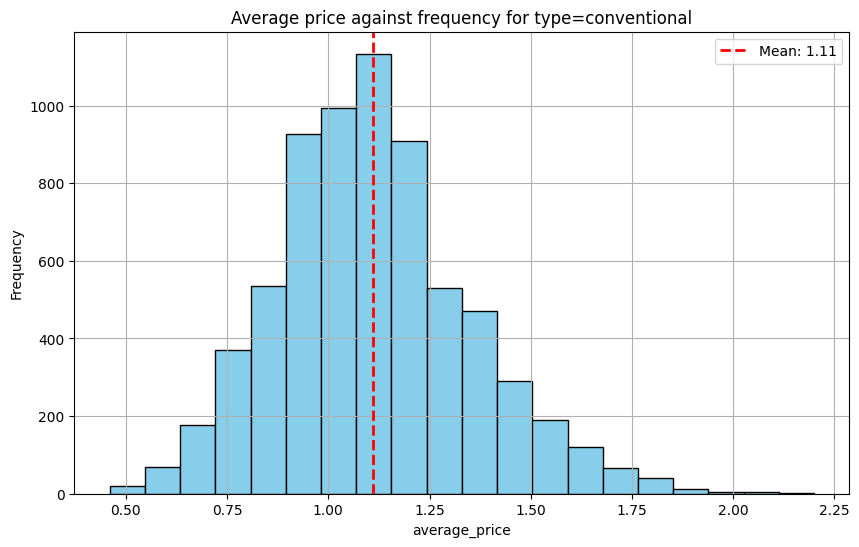

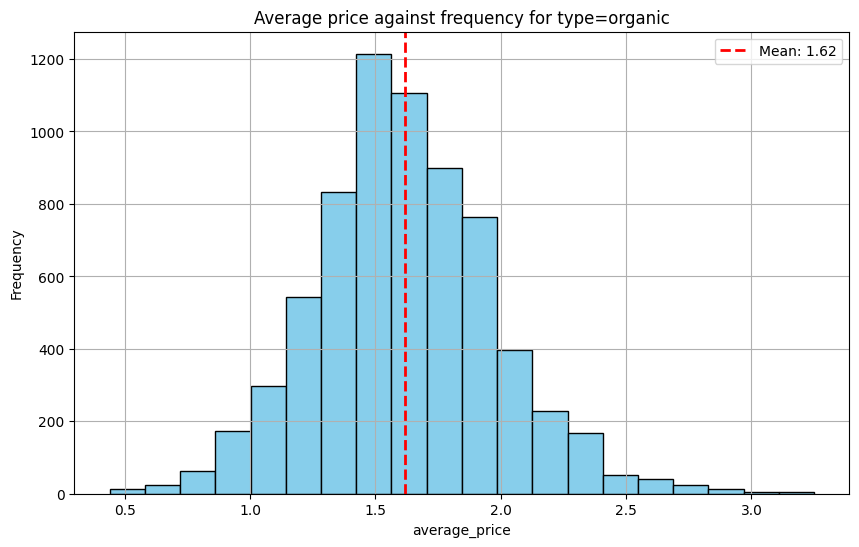

In [98]:
# plot the histograms
binned_histogram(df=eda_train_data_conventional,
                 binned_column='average_price',
                 plot_title='Average price against frequency for type=conventional',
                 )
binned_histogram(df=eda_train_data_organic,
                 binned_column='average_price',
                 plot_title='Average price against frequency for type=organic',
                 )




The aim of the charts above is to provide visualisation of the central tendency, variability and the shape of the price distributions.

- Both types of avocados have a roughly bell shaped distribution indicating that the average price is normally distributed.
- For conventional avocados the modal bin is similar to the mean.
- For organic avocados the modal bin is slightly lower than the mean.


Next Box Plots will be produced on the target variable, average_price to identify outliers.

The presence of outliers can effect the choice of algorithm for validating the predictions of the model.

The first chart is created using Plotly Dash to allow users to interact with the chart and view values for each of the boxes.

In [99]:
def produce_boxplots(df: pd.DataFrame, radio_switch: str, x_axis: str, y_axis: str)->None:
    """
    Produce a Horizontal BoxPlot using plotly dash for the x and y arguments

    Args:
        df (pd.DataFrame): DataFrame containing the data to be charted
        radio_switch (str): column to use as a radio button to switch the display
        x_axis (str): X axis for for the chart (column that you want to see the distribution and outliers for)
        y_axis (str): column contain

    Returns:
        None
    """


    boxplot_app = dash.Dash(__name__)

    boxplot_app.layout = html.Div([
        html.P(f'Select {radio_switch}:',
               style={
                'font-family': 'Arial',
                'backgroundColor': 'white',
                'width': '1400px'
            }),
        dcc.RadioItems(
            id='type-selector',
            options=[{'label': t, 'value': t} for t in df[radio_switch].unique()],
            value=df[radio_switch].unique()[0],
            inline=True,
            style={
                'font-family': 'Arial',
                'backgroundColor': 'white',
                'width': '1400px'
            }
        ),
        dcc.Graph(id="graph"),
    ])

    @boxplot_app.callback(
        Output("graph", "figure"),
        Input("type-selector", "value"))
    def generate_charts(selected_type):
        # Filter data based on selected type
        filtered_df = df[df[radio_switch] == selected_type]

        # Calculate mean average price for each region and sort
        mean_prices = filtered_df.groupby(y_axis)[x_axis].mean()
        sorted_regions = mean_prices.sort_values(ascending=False).index

        fig = go.Figure()
        fig.add_trace(go.Box(
            x=filtered_df[x_axis],
            y=filtered_df[y_axis],
            name=selected_type,
            orientation='h',
            boxmean=True  # Show the mean as a marker
        ))

        # Update layout for better presentation
        fig.update_layout(
            title=f'{x_axis} Distribution by {y_axis} for {radio_switch}: {selected_type}, Sorted by mean {x_axis}.',
            xaxis_title=x_axis,
            yaxis_title=y_axis,
            yaxis=dict(
                categoryorder='array',
                categoryarray=sorted_regions  # Set the order of regions based on sorted means
            ),
            width=1200,
            height=2000,
            xaxis = dict(showgrid=True, gridwidth=1, gridcolor='LightGrey'),
        )
        return fig

    if __name__ == '__main__':
        boxplot_app.run_server(debug=True)

## Box plots of prices by regions and type to identify outliers

In [100]:
#this takes a while to load in colab!
produce_boxplots(df=eda_train_data, radio_switch='type', x_axis='average_price', y_axis='region')


<IPython.core.display.Javascript object>

### Box Plots
The box plots above show that the are regions with and without outliers.  

Some of the regions, such as Chicago do not have outliers but have a very wide range which may make forecasting difficult.

As already mentioned there is a wide spread of Average Prices for the Regions and the Types which would indicate the predicting at a summarised level might hide this variability and lead to in accurate predictions.

## Feature creation


Historic data with lagged features and moving averages will be used to try to predict future prices.  (Shkulov, 2023)

As we are predicting 8 weeks into the future, the period used for these features will be 8 weeks.  The shorter the period for the lagged features the short the period for the prediction can be.  For example:  If features with a 1 week lag are used then the model will only be able to predict 1 week into the future.

Different combinations of columns will be tested but the actual data from the same day as the price will not be used in training as it would not be available for the prediction.

Functions will be created to assist with the feature creation and then a pipeline will be created to easily apply to train and test datasets.


In [101]:
def create_lagged_features(df, cols_to_lag, lagged_weeks, date_col='date'):
    """Creates lagged features for specified columns in a DataFrame.

    This function takes a DataFrame, a list of columns to lag, the number of weeks to lag by,
    and the name of the date column. It creates new columns in the DataFrame representing the
    lagged values of the specified columns, grouped by 'type' and 'region'.

    Args:
        df (pd.DataFrame): The input DataFrame containing the data.
        cols_to_lag (list): A list of column names to create lagged features for.
        lagged_weeks (int): The number of weeks to lag the data by.
        date_col (str, optional): The name of the date column in the DataFrame. Defaults to 'date'.

    Returns:
        tuple: A tuple containing:
            - pd.DataFrame: The DataFrame with the added lagged features.
            - list: A list of the names of the newly created lagged feature columns.
    """
    df = df.copy()
    df = df.set_index(date_col)
    df = df.sort_values(date_col)
    lagged_features = []

    for col in cols_to_lag:
        lagged_col = f'{col}_lag_1_year'
        df[f'{col}_lag_{str(lagged_weeks)}_weeks'] = df.groupby(['type', 'region'])[col].shift(lagged_weeks)
        lagged_features.append(lagged_col)

    df.reset_index(inplace=True)
    return df, lagged_features


def pre_processing(df: pd.DataFrame,
                   cols_to_lag: list,
                   weeks_to_lag: list,
                   moving_average_window: int = None,
                   date_range:list =None,
                   test_set:bool=False,
                   date_col:str ='date',
                   exclusion_window:int = 8,
                   target:str= 'average_price',
                   )->pd.DataFrame:
    """Prepares a time series DataFrame for modeling by creating lagged features and a moving average.

    This function performs the following steps:

    1. Creates lagged features for specified columns and lag periods.
    2. Calculates a rolling sum of the target variable with an exclusion window.
    3. Calculates the valid rolling window size for the moving average.
    4. Computes the moving average of the target variable.
    5. Optionally filters the DataFrame to a specific date range for test set creation.
    6. Renames the date and target columns to 'ds' and 'y' respectively.
    7. Analyzes the processed DataFrame (assumed to be a separate function).
    8. Returns the processed DataFrame.

    Args:
        df (pd.DataFrame): The input DataFrame containing the time series data.
        cols_to_lag (list): A list of column names to create lagged features for.
        weeks_to_lag (list): A list of integers representing the number of weeks to lag the data by.
        moving_average_window (int, optional): The window size for calculating the moving average.
                                                If None, the moving average calculation is skipped.
        date_range (list, optional): A list containing the start and end dates for filtering the test set
                                     (format: ['YYYY-MM-DD', 'YYYY-MM-DD']). Only used if `test_set` is True.
        test_set (bool, optional): If True, filters the DataFrame to the specified `date_range`. Defaults to False.
        date_col (str, optional): The name of the date column in the DataFrame. Defaults to 'date'.
        exclusion_window (int, optional): The exclusion window size for the rolling sum. Defaults to 8.
        target (str, optional): The name of the target variable column. Defaults to 'average_price'.

    Returns:
        pd.DataFrame: The processed DataFrame ready for time series modeling.
    """

    df = df.copy()
    # df = df.sort_values(date_col)

    for week in weeks_to_lag:
        df = create_lagged_features(df, cols_to_lag=cols_to_lag, lagged_weeks=week)[0]

    # Calculate the rolling sum with the exclusion window
    df['rolling_sum'] = (df[target].rolling(window=moving_average_window, min_periods=1)
                                       .sum()
                                       .shift(exclusion_window)
                                       .fillna(method='bfill'))

    # Calculate the valid rolling window size, accounting for edge cases
    df['rolling_count'] = (df[target].rolling(window=moving_average_window, min_periods=1)
                                         .count()
                                         .shift(exclusion_window)
                                         .fillna(method='bfill'))

    # calculate the moving average
    df[f'{target}_ma_{moving_average_window}_excl_{exclusion_window}'] = df['rolling_sum'] / df['rolling_count']

    df = df.drop(columns=['rolling_sum', 'rolling_count'])


    # drop NaN values (these will be dates to early to have lagged features)
    df = df.dropna()

    if test_set:
        start_date = date_range[0]
        end_date = date_range[1]
        df = df[(df[date_col] >= start_date) & (df[date_col] <= end_date)]
        # df = df[df['ds'] >= split_date]

    df = df.rename(columns={date_col: 'ds', target: 'y'})

    # print the analysis of the datasets for checking
    analyze_dataframe(df)

    return df


### Create the lagged and moving average features on train, test and validate sets

In [102]:

def get_min_max_dates_as_strings(df, date_column='date'):
    """ function to get the min and max dates from a dataframe"""
    df[date_column] = pd.to_datetime(df[date_column])
    min_date = df[date_column].min().strftime('%Y-%m-%d')
    max_date = df[date_column].max().strftime('%Y-%m-%d')
    return [min_date, max_date]


# create a list containing the colums to lag
columns_to_lag = ['average_price',
                # below items we removed as the were not selected by the feature selection process
                #  'total_volume' ,
                # 'type_plu4046',
                # 'type_plu4225',
                # 'type_plu4770',
                # 'xlarge_bags'
                 ]

# create a list for periods to lag the features
weeks_to_lag = [8,  12 , 16,  24]

# create a period for the moving average window
ma_window = 30

# create the features on the training set
train_min_max = get_min_max_dates_as_strings(train_data)
print("Train min/max: ", train_min_max)
print()
print("Analysis of train set post Feature Creation")
lagged_train_df = pre_processing(df=train_data,
                               cols_to_lag=columns_to_lag,
                               weeks_to_lag=weeks_to_lag,
                               moving_average_window=ma_window
                               )

# print(split_date)

# extract the min and max dates for the validate and test set
test_min_max = get_min_max_dates_as_strings(test_data)

val_min_max = get_min_max_dates_as_strings(val_data)


# create a new dataset contain all observations so the lagged features can be created on the val and test sets
test_data_concat = pd.concat([test_data, val_data, train_data])
test_data_concat.reset_index(drop=True, inplace=True)


# create features on the val set
print("Val min/max: ", val_min_max)
print()
print("Analysis of val set post Feature Creation")
lagged_val_df = pre_processing(df=test_data_concat,
                                cols_to_lag=columns_to_lag,
                                test_set=True,
                                date_range=val_min_max,
                                weeks_to_lag=weeks_to_lag,
                                moving_average_window=ma_window)


# create features on the test set
print("Test min/max: ", test_min_max)
print()
print("Analysis of test set post Feature Creation")
lagged_test_df = pre_processing(df=test_data_concat,
                                cols_to_lag=columns_to_lag,
                                test_set=True,
                                date_range=test_min_max,
                                weeks_to_lag=weeks_to_lag,
                                moving_average_window=ma_window)

Train min/max:  ['2015-01-04', '2017-06-04']

Analysis of train set post Feature Creation
* There are no null or missing values in the DataFrame.

*  No duplicate rows found in the DataFrame

NDV : Number of distinct Values
If NDV > 5 values will not be printed

| Column                     |                              |                          |                          |                                    |
|----------------------------|------------------------------|--------------------------|--------------------------|------------------------------------|
| ds                         | NDV: 103, (greater than 5)   | Min: 2015-06-21 00:00:00 | Max: 2017-06-04 00:00:00 | Avg: 2016-06-12 00:24:28.093140224 |
| y                          | NDV: 248, (greater than 5)   | Min: 0.44                | Max: 3.25                | Avg: 1.3647945698103028            |
| total_volume               | NDV: 11115, (greater than 5) | Min: 84.56               | Max: 61034457.1          | Avg: 8507

#### As lagged features with a 24 week window have been created the first 6 months of training data has been dropped due to null values - this can be seen in the first table above


For testing, lagged features have been created on multiple columns - these will be run through a feature selection algorithm (1.13. Feature selection — scikit-learn 1.5.1 documentation, no date)

Following the feature selection these were removed from the columns to lagged list above.  The function below was created with the assistance of Gemini Cloud Code.

In [103]:



def select_features(df, k=10):
    """
    Selects the k most relevant features for a time series dataset using f_regression.

    Args:
        df (pd.DataFrame): The time series DataFrame with 'ds' as the date column and 'y' as the target.
        k (int, optional): The number of top features to select. Defaults to 10.

    Returns:
        pd.DataFrame: A DataFrame containing only the selected features and the target variable 'y'.
    """

    df = df.copy()

    # convert 'ds' to datetime objects if not already
    df['ds'] = pd.to_datetime(df['ds'])

    # extract relevant features (excluding 'ds' and 'y')
    features = df.drop(columns=['ds', 'y'])

    # handle non-numeric columns
    for col in features.columns:
        if not pd.api.types.is_numeric_dtype(features[col]):
            features[col] = features[col].astype('category').cat.codes

    # ppply feature selection
    selector = SelectKBest(f_regression, k=k)
    selected_features = selector.fit_transform(features, df['y'])

    # get the names of the selected features
    selected_feature_names = features.columns[selector.get_support()]

    # create a new DataFrame with selected features and target
    selected_df = pd.DataFrame(selected_features, columns=selected_feature_names)
    selected_df['y'] = df['y']

    return selected_df




In [104]:
feature_selection_train_df = lagged_train_df.drop(
    ['type', 'region',
     'year', 'week', 'month',
     'total_volume',
     'total_bags' ,
     'small_bags',
     'large_bags',
    'type_plu4046',
    'type_plu4225',
    'type_plu4770',
    'xlarge_bags'], axis=1)

selected_df = select_features(feature_selection_train_df, k=5)  # Select the top 5 features
print(selected_df.columns)

# Output of feature selection:
#     Index(['average_price_lag_8_weeks', 'average_price_lag_12_weeks',
#        'average_price_lag_16_weeks', 'average_price_lag_24_weeks',
#        'average_price_ma_30_excl_8', 'y'],
#       dtype='object')

Index(['average_price_lag_8_weeks', 'average_price_lag_12_weeks',
       'average_price_lag_16_weeks', 'average_price_lag_24_weeks',
       'average_price_ma_30_excl_8', 'y'],
      dtype='object')


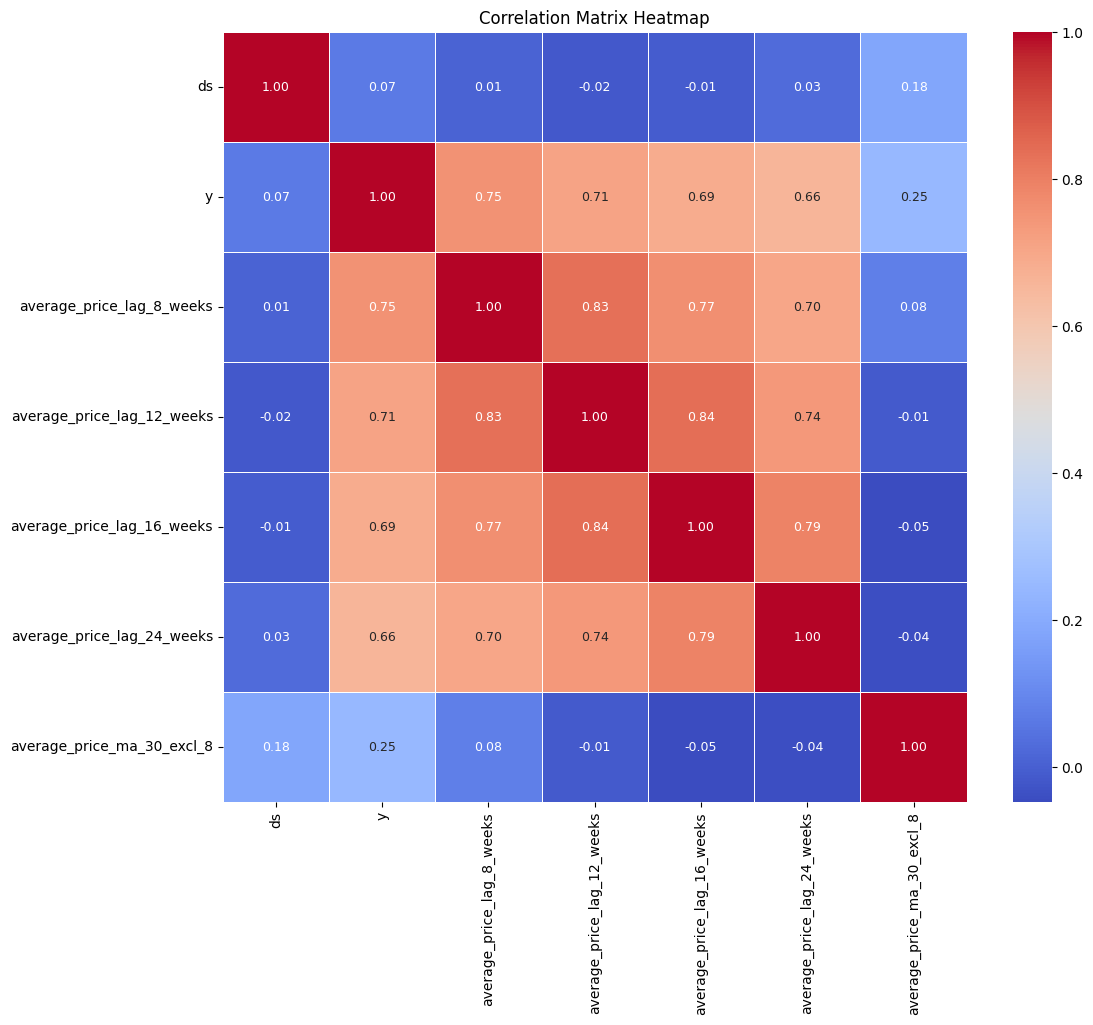

In [105]:


# function is from previous assignment - (Glover M,2024)

def visual_correlation_matrix(df: pd.DataFrame)->None:
    # Calculate correlation matrix
    correlation_matrix = df.corr()

    # Plot correlation matrix heatmap
    plt.figure(figsize=(12, 10))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.4,
                annot_kws={"fontsize":9})
    plt.title('Correlation Matrix Heatmap')
    plt.show()


visual_correlation_matrix(lagged_train_df.drop(
    ['type', 'region',
     'year', 'week', 'month',
     'total_volume',
     'total_bags' ,
     'small_bags',
     'large_bags',
    'type_plu4046',
    'type_plu4225',
    'type_plu4770',
    'xlarge_bags'], axis=1))

The correlation matrix above shows that the closer to the target date the lagged features get the higher the correlation with the price is.



In [106]:
# one hot encoding function
def one_hot_encode_columns(df: pd.DataFrame, categorical_cols:list)->pd.DataFrame:
    """One hot encodes a list of columns in a DataFrame

    Args:
        df (pd.DataFrame): DataFrame to one hot encode
        categorical_cols (list): list of columns to encode

    Returns:
        pd.DataFrame: DataFrame with columns encoded
        list: a list containing the encoded column names
    """

    df = df.copy()
    # columns_to_encode = [col for col in categorical_cols if col != 'date']
    preprocessor = ColumnTransformer(
        transformers=[('onehot', OneHotEncoder(handle_unknown='ignore'), categorical_cols)],
        remainder='passthrough'  # Keep other columns unchanged
    )

    df_temp = preprocessor.fit_transform(df)

    if not isinstance(df_temp, np.ndarray):
        df_temp = df_temp.toarray()

    encoded_columns_tmp = preprocessor.get_feature_names_out()

    encoded_columns = [item for item in encoded_columns_tmp if 'onehot__' in item]

    df = pd.DataFrame(df_temp, columns=preprocessor.get_feature_names_out())
    # print(df.columns)
    df.columns = df.columns.str.replace('remainder__', '', regex=False)
    # df = pd.DataFrame(df_temp, columns=encoded_columns)

    return df, encoded_columns



In [107]:
def calculate_rmse_by_source(df: pd.DataFrame) -> pd.DataFrame:
    """
    Calculates the Root Mean Squared Error (RMSE) for each 'source' in the DataFrame.

    Args:
        df (pd.DataFrame): DataFrame containing columns 'source', 'y' (actual values), and 'yhat' (predicted values).

    Returns:
        pd.DataFrame: DataFrame with 'source' and corresponding 'rmse' values.
    """

    grouped_df = df.groupby('source')[['y', 'yhat']]

    rmse_df = (grouped_df.apply(lambda x: np.sqrt(mean_squared_error(x['y'], x['yhat'])))
               .reset_index(name='rmse'))

    return rmse_df

## Model Selection and Processing

### Models
Based on research 3 models have been chosen for testing on the price prediction problem.

The choosen models for testing are:

- Facebook's Prophet Model
- XGBoost
- Random Forest Regressor

ARIMA models are widely used in time series predictions but many scientists now use Facebook's Prophet Model (Prophet | Forecasting at scale., no date).  Before using ARIMA models tests need to be carried out to test the data for Stationarity, using the Augmented Dicky-Fuller test or similar (Nielsen, 2019), then take actions if the data not stationary before applying a model such as applying differencing (Hyndman and Athanasopoulos, 2021). Prophet makes working with time series data much simpler than ARIMA (Vasselin and Bertrand, 2022).

XGBoost is cited in research as being a good predictor for Time Series problems (Kerkstoel, 2020), and Shkulov (2023) also recommends it.  It is also very easy to expalain the key predictors

Brownlee (2020) discusses how Random Forest Regressors are suitable for Time Series prediction.  Random Forest is also easy to explain.

### Testing

RMSE is a widely used metric for regression problems (Gupta, 2023) and will be used here to measure effectiveness of the models as it is easy to understand and interpret due to it being in the same units as the target.  Visualisations will also be produced to see how well the prediction track the actuals.

### Hyperparameter Tuning

This will be carried out on Prophet by testing against the RMSE based on a grid of parameters, then reviewed against the Validation set to see if the model has over-fit or generalises well.

For XGBoost and Random forest Walk Forward validation will be used instead of Cross Validation.  Cross Validation uses Random Splits so it will be looking at the future when testing predictions (Brownlee, 2020).  It also works without needing to scale variables.  Again after each iteration the train RMSE will be compared to the Validation RMSE to see if has over-fit and how accurate the model is.

Functions will be built to allow for repeated processing and testing

### Results and Testing

The resulting models will then be run on the training set and visualisations produced.

Where possible these will be kept the same.

# Train Facebook's Prophet model on the dataset.

As mentioned the aim of this analysis is to try to forecast or predict the future prices of avocados for a particular type and region.

The regions and types will be trained individually, as Prophet requires the date to be distinct, then the datasets will be joined together for visualisations.


In [108]:

np.float_ = np.float64 # this line is needed due to issues with np.float and prophet
from prophet import Prophet

import logging


# Set logging level to WARNING (or higher)
logging.getLogger('prophet').setLevel(logging.WARNING)

In [109]:
# prophet pipeline

desired_order = ['ds',
                 'y',
                 'type',
                 'region',
                 ]
# + lagged_features


feature_columns = [col for col in lagged_train_df.columns if '_lag_' in col or '_ma_' in col]
# + ['month']
# feature_columns = [col for col in lagged_train_df.columns if '_ma_' in col]

print(feature_columns)




['average_price_lag_8_weeks', 'average_price_lag_12_weeks', 'average_price_lag_16_weeks', 'average_price_lag_24_weeks', 'average_price_ma_30_excl_8']


In [110]:

# train and hyperparameter tune

def train_and_test_prophet_on_avo_gs(
    target_region: str,
    target_type: str,
    train_data: pd.DataFrame,
    val_data: pd.DataFrame,
    desired_order: list,
    param_grid:dict,
    target_col='y',
    date_col='ds',
    lagged_features: list = None,
    chart_results:bool=False
)->Prophet:
    """Trains and evaluates a Prophet time series model on avocado price data.

    This function filters the provided training and testing data for a specific region and avocado type,
    trains a Prophet model using the specified parameters, and evaluates the model's performance on the test data.
    It also provides visualizations of the forecast and its components.

    Args:
        target_region (str): The region for which to build the model (e.g., 'Albany').
        target_type (str): The type of avocado  (e.g., 'conventional').
        train_data (pd.DataFrame): DataFrame containing the training data with columns for 'region', 'type', 'ds' (datestamp), 'y' (target variable), and any lagged features.
        test_data (pd.DataFrame): DataFrame containing the test data with the same columns as train_data.
        desired_order (list): A list of column names specifying the order of columns in the input dataframes. This should include 'ds' (datestamp) and 'y' (target variable).
        yearly_seasonality (bool): Whether to include yearly seasonality in the model.
        seasonality_prior_scale (float): Strength of the prior belief in the seasonality.
        changepoint_prior_scale (float): Strength of the prior belief in the changepoints.
        seasonality_mode (str): Seasonality mode ('additive' or 'multiplicative').
        lagged_features (list, optional): A list of column names representing lagged features to include as regressors in the model. Defaults to None.

    Returns:
        Prophet: The trained Prophet model object.
    """
    # hide warnings relating to Deprecation of a pandas datetime feature
    import warnings
    warnings.filterwarnings("ignore", category=FutureWarning)

    best_rmse = float('inf')
    best_model = None
    best_params = None


    # filter train and test to the target region
    query = f"region == '{target_region}' & type == '{target_type}'"
    train_df = train_data.query(query)
    val_df = val_data.query(query)


    if lagged_features != None:
        desired_order = desired_order + lagged_features

    # keep the required columns
    train_df = train_df[desired_order]
    val_df = val_df[desired_order]

    # create the model and add seasonality
    for params in ParameterGrid(param_grid):
        model = Prophet(**params)
        if lagged_features != None:
            for col in lagged_features:
                model.add_regressor(col)
        model.fit(train_df)


        # Make predictions on the training data
        forecast = model.predict(train_df)
        y_pred = forecast['yhat'].values
        y_true = train_df[target_col].values
        rmse = mean_squared_error(y_true, y_pred, squared=False)

        if rmse < best_rmse:
            best_rmse = rmse
            best_model = model
            best_params = params

    print("Best RMSE:", best_rmse)
    print("Best Parameters:", best_params)


    # apply the model to the test data
    train_forecast = best_model.predict(train_df.reset_index())
    val_forecast = best_model.predict(val_df.reset_index())
    # forecast = best_model.predict(test_df.reset_index())

    y_true = val_df['y'].values
    y_pred = val_forecast.loc[val_forecast[date_col].isin(val_df[date_col]), 'yhat'].values
    val_rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f'RMSE: {val_rmse}')

    # Plot the forecast
    # model.plot(forecast)

    # # Plot the components (trend, seasonality, etc.)
    # model.plot_components(forecast)

    if chart_results:
    # Generate component plots
        # fig_components = best_model.plot_components(forecast)

        # Create a new figure for forecast vs. actual
        fig_forecast = go.Figure()

        # Add trace for actual data (full dataset)
        fig_forecast.add_trace(go.Scatter(x=train_df[date_col], y=train_df[target_col], mode='lines', name='Actual (Full Data)'))


        # Add trace for actual data (val set only)
        fig_forecast.add_trace(go.Scatter(x=val_df[date_col], y=val_df[target_col], mode='lines', name='Actual (Val Data)'))

        # Add trace for forecasts
        fig_forecast.add_trace(go.Scatter(x=train_forecast[date_col], y=train_forecast['yhat'], mode='lines', name='Train Forecast'))
        fig_forecast.add_trace(go.Scatter(x=val_forecast[date_col], y=val_forecast['yhat'], mode='lines', name='Val Forecast'))

        # Update layout
        fig_forecast.update_layout(title=f'Actual vs. Forecasted Values for Train and Validate - Region: {target_region}, Type: {target_type}',
                                xaxis_title='Date',
                                yaxis_title='Value')

        # Show both plots
        # fig_components.show()
        fig_forecast.show()
    return best_model, best_params, best_rmse, val_rmse,



Iterations of different hyperparameters were tested on the total regions, to avoid many interations of runs on a large numer of regions.

Following each run the RMSE for the train and validate sets was reviewed to see if the model had overfit, and how this could be improved upon.

It will be tested if these parameter work well on the individual regions.

Google Gemini assisted with Hyperparameter tuning.


In [111]:
# param_grid = {
#     'yearly_seasonality': [True],
#     'seasonality_mode': ['additive', 'multiplicative'],
#     'changepoint_prior_scale': [0.01, 0.1, 0.5],
#     'seasonality_prior_scale': [0.01, 0.1, 1.0],
#     'holidays_prior_scale': [0.01, 0.1, 1.0],  # Add holidays_prior_scale
#     'n_changepoints': [10, 25],          # Add n_changepoints
#     # 'changepoint_range': [0.8, 0.9, 0.95]    # Add changepoint_range
# }

# param_grid = {
#     'changepoint_prior_scale': [0.05, 0.1, 0.2],  # Reduced range, favoring fewer changepoints
#     'seasonality_prior_scale': [0.1, 1.0],
#     'holidays_prior_scale': [0.01, 0.1],
#     'yearly_seasonality': [True, False],  # Consider whether yearly seasonality is truly necessary
#     'seasonality_mode': ['additive', 'multiplicative'],
#     'n_changepoints': [5, 10, 15]  # Limit the number of potential changepoints
# }

# param_grid = {
#     'changepoint_prior_scale': [0.01, 0.05, 0.1],   # Further reduce flexibility
#     'seasonality_prior_scale': [0.1, 1.0, 5.0, 10.0], # Explore stronger seasonality
#     'holidays_prior_scale': [0.01, 0.1],
#     'yearly_seasonality': [True],   # Keep yearly seasonality for now
#     'seasonality_mode': ['multiplicative'],
#     'n_changepoints': [5, 10]        # Further limit changepoints
# }

# param_grid = {
#     'changepoint_prior_scale': [0.05, 0.1, 0.15],
#     'seasonality_prior_scale': [3.0, 5.0, 7.0],
#     'holidays_prior_scale': [0.01, 0.1],
#     'yearly_seasonality': [True],
#     'seasonality_mode': ['multiplicative'],
#     'n_changepoints': [3, 5, 7]
# }

# param_grid = {
#     'yearly_seasonality': [True],
#     'changepoint_prior_scale': [0.05, 0.1, 0.15, 2],   # Explore slightly higher values for trend flexibility
#     'seasonality_prior_scale': [0.1, 1.0, 3.0],    # Increase the range to capture stronger seasonality
#     'holidays_prior_scale': [0.01, 0.1],
#     'yearly_seasonality': [True],
#     'seasonality_mode': ['additive', 'multiplicative'], # Consider both modes
#     'n_changepoints': [5, 10, 12 ],       # Slightly increase the potential number of changepoints
# }

# param_grid = {
#     'changepoint_prior_scale': [0.001, 0.01, 0.05],
#     'seasonality_prior_scale': [0.01, 0.1, 1.0],
#     'holidays_prior_scale': [0.01, 0.1],
#     'yearly_seasonality': [True],
#     'seasonality_mode': ['additive'],
#     'n_changepoints': [0, 3, 5]
# }

# param_grid = {
#     'changepoint_prior_scale': [0.005, 0.01, 0.02],  # Explore even smoother trends
#     'seasonality_prior_scale': [0.5, 1.0, 2.0],
#     'holidays_prior_scale': [0.01, 0.1],
#     'yearly_seasonality': [True],
#     'seasonality_mode': ['additive'],
#     'n_changepoints': [0]  # Stick with no changepoints for now
# }

# param_grid = {
#     'changepoint_prior_scale': [0.01, 0.02, 0.03],
#     'seasonality_prior_scale': [0.3, 0.5, 0.7],
#     'holidays_prior_scale': [0.01, 0.1],
#     'yearly_seasonality': [True],
#     'seasonality_mode': ['additive'],
#     'n_changepoints': [0]
# }


In [112]:
# run the data through the prohpet model

# best params organic
organic_param_grid = {'changepoint_prior_scale': [0.01],
                      'holidays_prior_scale':[ 0.1],
                      'n_changepoints': [0],
                      'seasonality_mode': ['additive'],
                      'seasonality_prior_scale': [0.7],
                      'yearly_seasonality': [True]}




train_and_test_prophet_on_avo_gs(
    target_region = 'TotalUS',
    target_type = 'organic',
    train_data = lagged_train_df,
    val_data= lagged_val_df,
    desired_order = desired_order,
    lagged_features = feature_columns,
    param_grid= organic_param_grid,
    chart_results=True
)

train_and_test_prophet_on_avo_gs(
    target_region = 'West',
    target_type = 'organic',
    train_data = lagged_train_df,
    val_data= lagged_val_df,
    desired_order = desired_order,
    lagged_features = feature_columns,
    param_grid= organic_param_grid,
    chart_results=True
)

# Best Params : Conventional
conventional_param_grid = {
    'changepoint_prior_scale': [ 0.03],
    'seasonality_prior_scale': [0.3],
    'holidays_prior_scale': [0.1],
    'yearly_seasonality': [True],
    'seasonality_mode': ['additive'],
    'n_changepoints': [0]
}

#  'PhoenixTucson', 'BuffaloRochester'

train_and_test_prophet_on_avo_gs(
    target_region = 'TotalUS',
    target_type = 'conventional',
    train_data = lagged_train_df,
    val_data= lagged_val_df,
    desired_order = desired_order,
    lagged_features = feature_columns,
    param_grid= conventional_param_grid,
    chart_results=True
)


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/xt5pq7cx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/n3ylnm1v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82895', 'data', 'file=/tmp/tmpkuqttylj/xt5pq7cx.json', 'init=/tmp/tmpkuqttylj/n3ylnm1v.json', 'output', 'file=/tmp/tmpkuqttylj/prophet_modelv0_6brra/prophet_model-20240903133414.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:34:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:34:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Best RMSE: 0.11830907390700773
Best Parameters: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.7, 'yearly_seasonality': True}
RMSE: 0.346210741032248


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/nqv092t7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/t_7hj_co.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70162', 'data', 'file=/tmp/tmpkuqttylj/nqv092t7.json', 'init=/tmp/tmpkuqttylj/t_7hj_co.json', 'output', 'file=/tmp/tmpkuqttylj/prophet_model5p298zf0/prophet_model-20240903133415.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:34:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:34:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
13:34:15 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/l77h090n.json
DE

Best RMSE: 0.12548642808303787
Best Parameters: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.7, 'yearly_seasonality': True}
RMSE: 0.5379480523927549


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/v9oc67d1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/ibwhfhwc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96634', 'data', 'file=/tmp/tmpkuqttylj/v9oc67d1.json', 'init=/tmp/tmpkuqttylj/ibwhfhwc.json', 'output', 'file=/tmp/tmpkuqttylj/prophet_model2p9u0xsi/prophet_model-20240903133416.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:34:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:34:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Best RMSE: 0.05425010289653953
Best Parameters: {'changepoint_prior_scale': 0.03, 'holidays_prior_scale': 0.1, 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.3, 'yearly_seasonality': True}
RMSE: 0.10610622821619789


(<prophet.forecaster.Prophet at 0x781bdfd08520>,
 {'changepoint_prior_scale': 0.03,
  'holidays_prior_scale': 0.1,
  'n_changepoints': 0,
  'seasonality_mode': 'additive',
  'seasonality_prior_scale': 0.3,
  'yearly_seasonality': True},
 0.05425010289653953,
 0.10610622821619789)

For Prophet the predictions on the Conventional Avocodos are Better than for Organic.  

This could be due to the value of 1 for a few weeks in July 2015 causing issues for the model.  THis could be solved by creating an average data set for all regions to use in training.

**External reaseach has shown that there was an unusual price rise in Avocados in mid to late 2017 that could be skeweing the training data (Kaur, 2017).  Future data could include news reports on avodado prices**

Now the params from the training above will be used to train Prophet on the entire set and also test against the test set.

The params for organic and convention will dynanamcially passed in during modelling.

In [113]:
# Group by region and type
grouped_df = lagged_train_df.groupby(['region', 'type'])
results = []
rmse_by_region_type = []

# Train and test models for each group
for (region, type), group_df in grouped_df:
    if type == 'organic':
        param_grid = organic_param_grid
    elif type == 'conventional':
        param_grid = conventional_param_grid
    else:
        print('error - type not in organic / conventional')
    model, best_params, best_rmse, val_rmse = train_and_test_prophet_on_avo_gs(
        target_region=region,
        target_type=type,
        train_data=lagged_train_df,
        val_data=lagged_val_df,
        desired_order=desired_order,
        lagged_features=feature_columns,
        param_grid=param_grid
    )

    # Make predictions on all sets
    train_forecast = model.predict(lagged_train_df.query(f"region == '{region}' & type == '{type}'").reset_index())
    val_forecast = model.predict(lagged_val_df.query(f"region == '{region}' & type == '{type}'").reset_index())
    test_forecast = model.predict(lagged_test_df.query(f"region == '{region}' & type == '{type}'").reset_index())

    # Create DataFrames for each set with actuals and predictions
    train_results = lagged_train_df.query(f"region == '{region}' & type == '{type}'").reset_index()[['ds', 'y']].merge(train_forecast[['ds', 'yhat']], on='ds', how='left')
    val_results = lagged_val_df.query(f"region == '{region}' & type == '{type}'").reset_index()[['ds', 'y']].merge(val_forecast[['ds', 'yhat']], on='ds', how='left')
    test_results = lagged_test_df.query(f"region == '{region}' & type == '{type}'").reset_index()[['ds', 'y']].merge(test_forecast[['ds', 'yhat']], on='ds', how='left')


    # calcalute RMSE for the test set:
    y_true = test_results['y'].values
    y_pred = test_results['yhat'].values
    test_rmse = np.sqrt(mean_squared_error(y_true, y_pred))


    # Add 'region' and 'type' columns
    train_results['region'] = region
    train_results['type'] = type
    train_results['source'] = 'train'
    val_results['region'] = region
    val_results['type'] = type
    val_results['source'] = 'validate'
    test_results['region'] = region
    test_results['type'] = type
    test_results['source'] = 'test'

    # Append to the results list
    results.append(train_results)
    results.append(val_results)
    results.append(test_results)

    rmse_output = {
            'region': region,
            'type': type,
            'train_rmse': best_rmse,
            'val_rmse': val_rmse,
            'test_rmse': test_rmse
        }

    rmse_by_region_type.append(rmse_output)


    print(f"Model trained for region: {region}, type: {type}")

# Concatenate all results into a single DataFrame
all_results_df = pd.concat(results, ignore_index=True)

all_rmse_df = pd.DataFrame(rmse_by_region_type)






DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/3qdulnuw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/pc1f3ya2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56724', 'data', 'file=/tmp/tmpkuqttylj/3qdulnuw.json', 'init=/tmp/tmpkuqttylj/pc1f3ya2.json', 'output', 'file=/tmp/tmpkuqttylj/prophet_modeli8fg09p5/prophet_model-20240903133417.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:34:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:34:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
13:34:17 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/fn41tn5e.json
DE

Best RMSE: 0.1280049080932043
Best Parameters: {'changepoint_prior_scale': 0.03, 'holidays_prior_scale': 0.1, 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.3, 'yearly_seasonality': True}
RMSE: 0.16057667779409324


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/ydrr0eu_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/0qkkcuae.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87105', 'data', 'file=/tmp/tmpkuqttylj/ydrr0eu_.json', 'init=/tmp/tmpkuqttylj/0qkkcuae.json', 'output', 'file=/tmp/tmpkuqttylj/prophet_models2pf789s/prophet_model-20240903133418.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:34:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:34:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
13:34:18 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/qgqr3lgz.json


Model trained for region: Albany, type: conventional


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/b7o000e_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85396', 'data', 'file=/tmp/tmpkuqttylj/qgqr3lgz.json', 'init=/tmp/tmpkuqttylj/b7o000e_.json', 'output', 'file=/tmp/tmpkuqttylj/prophet_modelzetpl580/prophet_model-20240903133418.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:34:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:34:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Best RMSE: 0.09170114654305708
Best Parameters: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.7, 'yearly_seasonality': True}
RMSE: 0.32268428492425416


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/shfmuhoi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/xynjn75h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83537', 'data', 'file=/tmp/tmpkuqttylj/shfmuhoi.json', 'init=/tmp/tmpkuqttylj/xynjn75h.json', 'output', 'file=/tmp/tmpkuqttylj/prophet_modeljzij2c1_/prophet_model-20240903133420.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:34:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:34:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
13:34:20 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted


Model trained for region: Albany, type: organic


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/n5yt1tz4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/rrn3pqsj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17539', 'data', 'file=/tmp/tmpkuqttylj/n5yt1tz4.json', 'init=/tmp/tmpkuqttylj/rrn3pqsj.json', 'output', 'file=/tmp/tmpkuqttylj/prophet_modelb9vvr2f2/prophet_model-20240903133420.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:34:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:34:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Best RMSE: 0.07895813451755074
Best Parameters: {'changepoint_prior_scale': 0.03, 'holidays_prior_scale': 0.1, 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.3, 'yearly_seasonality': True}
RMSE: 0.11674683215248331


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/minmmqhz.json


Model trained for region: Atlanta, type: conventional


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/9kl3ltx8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71745', 'data', 'file=/tmp/tmpkuqttylj/minmmqhz.json', 'init=/tmp/tmpkuqttylj/9kl3ltx8.json', 'output', 'file=/tmp/tmpkuqttylj/prophet_modelfxzf1sro/prophet_model-20240903133423.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:34:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:34:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
13:34:23 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/dgvvop__.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/vndmouvv.json
DE

Best RMSE: 0.2089782826594478
Best Parameters: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.7, 'yearly_seasonality': True}
RMSE: 1.0251289601555504


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/edh3ofnj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/e26ryi0x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5441', 'data', 'file=/tmp/tmpkuqttylj/edh3ofnj.json', 'init=/tmp/tmpkuqttylj/e26ryi0x.json', 'output', 'file=/tmp/tmpkuqttylj/prophet_modelish10f18/prophet_model-20240903133425.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:34:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Model trained for region: Atlanta, type: organic


13:34:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Best RMSE: 0.08536248246103491
Best Parameters: {'changepoint_prior_scale': 0.03, 'holidays_prior_scale': 0.1, 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.3, 'yearly_seasonality': True}
RMSE: 0.4007033409245594


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/puafuri5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/uogrlsih.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67443', 'data', 'file=/tmp/tmpkuqttylj/puafuri5.json', 'init=/tmp/tmpkuqttylj/uogrlsih.json', 'output', 'file=/tmp/tmpkuqttylj/prophet_modelzjfsqkdf/prophet_model-20240903133426.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:34:26 - cmdstanpy - INFO - Chain [1] start processing


Model trained for region: BaltimoreWashington, type: conventional


INFO:cmdstanpy:Chain [1] start processing
13:34:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
13:34:26 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/fymqjarx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/r7gq8xdv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99728', 'data', 'file=/tmp/tmpkuqttylj/fymqjarx.json', 'init=/tmp/tmpkuqttylj/r7gq8xdv.json', 'output', 'file=/tmp/tmpkuqttylj/prophet_modelytzton8f/prophet_model-20240903133426.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:34:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:34:26 - cmdstanpy -

Best RMSE: 0.09911881763123412
Best Parameters: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.7, 'yearly_seasonality': True}
RMSE: 0.5982384623611839


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/wy1ywxn9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/esspy4e3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99993', 'data', 'file=/tmp/tmpkuqttylj/wy1ywxn9.json', 'init=/tmp/tmpkuqttylj/esspy4e3.json', 'output', 'file=/tmp/tmpkuqttylj/prophet_model4s2ksim4/prophet_model-20240903133428.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:34:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:34:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
13:34:28 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted


Model trained for region: BaltimoreWashington, type: organic


ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/i3o2a32n.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/xemkh8co.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81689', 'data', 'file=/tmp/tmpkuqttylj/i3o2a32n.json', 'init=/tmp/tmpkuqttylj/xemkh8co.json', 'output', 'file=/tmp/tmpkuqttylj/prophet_model9hrdd97y/prophet_model-20240903133428.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:34:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:34:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Best RMSE: 0.08042865081031546
Best Parameters: {'changepoint_prior_scale': 0.03, 'holidays_prior_scale': 0.1, 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.3, 'yearly_seasonality': True}
RMSE: 0.20896176281591602


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/0n949ny6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/dmxd1c2y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35345', 'data', 'file=/tmp/tmpkuqttylj/0n949ny6.json', 'init=/tmp/tmpkuqttylj/dmxd1c2y.json', 'output', 'file=/tmp/tmpkuqttylj/prophet_modelt9vvdrpg/prophet_model-20240903133429.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:34:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:34:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
13:34:29 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/r7daj6u_.json


Model trained for region: Boise, type: conventional


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/tv_b23eq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28489', 'data', 'file=/tmp/tmpkuqttylj/r7daj6u_.json', 'init=/tmp/tmpkuqttylj/tv_b23eq.json', 'output', 'file=/tmp/tmpkuqttylj/prophet_modelukyk90yg/prophet_model-20240903133430.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:34:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:34:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Best RMSE: 0.24617839273476566
Best Parameters: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.7, 'yearly_seasonality': True}
RMSE: 0.9283331210018558


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/gblcl6hj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/trkoz4ia.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70770', 'data', 'file=/tmp/tmpkuqttylj/gblcl6hj.json', 'init=/tmp/tmpkuqttylj/trkoz4ia.json', 'output', 'file=/tmp/tmpkuqttylj/prophet_modeld_clj5pp/prophet_model-20240903133431.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:34:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Model trained for region: Boise, type: organic


13:34:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Best RMSE: 0.08212924674550177
Best Parameters: {'changepoint_prior_scale': 0.03, 'holidays_prior_scale': 0.1, 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.3, 'yearly_seasonality': True}
RMSE: 0.2926318006377163


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/cm71ahav.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/1mji0se4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15942', 'data', 'file=/tmp/tmpkuqttylj/cm71ahav.json', 'init=/tmp/tmpkuqttylj/1mji0se4.json', 'output', 'file=/tmp/tmpkuqttylj/prophet_model_g2jsf52/prophet_model-20240903133432.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:34:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:34:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
13:34:32 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted


Model trained for region: Boston, type: conventional


ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/tanv1r4l.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/9quzkiz5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80156', 'data', 'file=/tmp/tmpkuqttylj/tanv1r4l.json', 'init=/tmp/tmpkuqttylj/9quzkiz5.json', 'output', 'file=/tmp/tmpkuqttylj/prophet_modeluzym7su7/prophet_model-20240903133432.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:34:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:34:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Best RMSE: 0.1608784750092189
Best Parameters: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.7, 'yearly_seasonality': True}
RMSE: 0.3482589395883782


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/06d8tm4g.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/bkttw3em.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72740', 'data', 'file=/tmp/tmpkuqttylj/06d8tm4g.json', 'init=/tmp/tmpkuqttylj/bkttw3em.json', 'output', 'file=/tmp/tmpkuqttylj/prophet_modeln9d_c872/prophet_model-20240903133433.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:34:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:34:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
13:34:34 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/ae3vazgr.json


Model trained for region: Boston, type: organic


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/l6mh68o6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7096', 'data', 'file=/tmp/tmpkuqttylj/ae3vazgr.json', 'init=/tmp/tmpkuqttylj/l6mh68o6.json', 'output', 'file=/tmp/tmpkuqttylj/prophet_modeljzbyd1c2/prophet_model-20240903133434.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:34:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:34:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Best RMSE: 0.07920749145918198
Best Parameters: {'changepoint_prior_scale': 0.03, 'holidays_prior_scale': 0.1, 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.3, 'yearly_seasonality': True}
RMSE: 0.5303783878266791


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/i2kr5pss.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/52l549kx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72917', 'data', 'file=/tmp/tmpkuqttylj/i2kr5pss.json', 'init=/tmp/tmpkuqttylj/52l549kx.json', 'output', 'file=/tmp/tmpkuqttylj/prophet_modelshhsihuy/prophet_model-20240903133436.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']


Model trained for region: BuffaloRochester, type: conventional


13:34:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:34:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
13:34:36 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/ev3_xf6i.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/a039tzxy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7660', 'data', 'file=/tmp/tmpkuqttylj/ev3_xf6i.json', 'init=/tmp/tmpkuqttylj/a039tzxy.json', 'output', 'file=/tmp/tmpkuqttylj/prophet_model2s0zbdca/prophet_model-20240903133436.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:34:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmd

Best RMSE: 0.12616620077241936
Best Parameters: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.7, 'yearly_seasonality': True}
RMSE: 0.8149535401076367


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/28vdg8y6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/lwk1dg36.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16152', 'data', 'file=/tmp/tmpkuqttylj/28vdg8y6.json', 'init=/tmp/tmpkuqttylj/lwk1dg36.json', 'output', 'file=/tmp/tmpkuqttylj/prophet_model0slf3ppw/prophet_model-20240903133438.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:34:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:34:38 - cmdstanpy - INFO - Chain [1] done processing


Model trained for region: BuffaloRochester, type: organic


INFO:cmdstanpy:Chain [1] done processing
13:34:38 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/0bkc1nh4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/yit1835e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42704', 'data', 'file=/tmp/tmpkuqttylj/0bkc1nh4.json', 'init=/tmp/tmpkuqttylj/yit1835e.json', 'output', 'file=/tmp/tmpkuqttylj/prophet_modelhifi_vec/prophet_model-20240903133438.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:34:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:34:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Best RMSE: 0.08615878164910176
Best Parameters: {'changepoint_prior_scale': 0.03, 'holidays_prior_scale': 0.1, 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.3, 'yearly_seasonality': True}
RMSE: 0.1659342815855624


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/gfr3hq7b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/mtfrxmyb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30231', 'data', 'file=/tmp/tmpkuqttylj/gfr3hq7b.json', 'init=/tmp/tmpkuqttylj/mtfrxmyb.json', 'output', 'file=/tmp/tmpkuqttylj/prophet_modelrv2_3acm/prophet_model-20240903133440.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:34:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:34:40 - cmdstanpy - INFO - Chain [1] done processing


Model trained for region: California, type: conventional


INFO:cmdstanpy:Chain [1] done processing
13:34:40 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/4nv6dqhq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/_us07ya5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44566', 'data', 'file=/tmp/tmpkuqttylj/4nv6dqhq.json', 'init=/tmp/tmpkuqttylj/_us07ya5.json', 'output', 'file=/tmp/tmpkuqttylj/prophet_model8rpfsn6c/prophet_model-20240903133440.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:34:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:34:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Best RMSE: 0.1387964719770189
Best Parameters: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.7, 'yearly_seasonality': True}
RMSE: 0.26104830733563306


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/phkv4jsw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/91h3l7sa.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56989', 'data', 'file=/tmp/tmpkuqttylj/phkv4jsw.json', 'init=/tmp/tmpkuqttylj/91h3l7sa.json', 'output', 'file=/tmp/tmpkuqttylj/prophet_model3qn1p8qp/prophet_model-20240903133441.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:34:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:34:41 - cmdstanpy - INFO - Chain [1] done processing


Model trained for region: California, type: organic


INFO:cmdstanpy:Chain [1] done processing
13:34:41 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/6klfbllf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/_efqsr7b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90816', 'data', 'file=/tmp/tmpkuqttylj/6klfbllf.json', 'init=/tmp/tmpkuqttylj/_efqsr7b.json', 'output', 'file=/tmp/tmpkuqttylj/prophet_modeljtmdf0l2/prophet_model-20240903133441.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:34:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:34:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Best RMSE: 0.06305879158628484
Best Parameters: {'changepoint_prior_scale': 0.03, 'holidays_prior_scale': 0.1, 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.3, 'yearly_seasonality': True}
RMSE: 0.25075879036840193


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/d1zz0o8v.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/8zkuzwl1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17873', 'data', 'file=/tmp/tmpkuqttylj/d1zz0o8v.json', 'init=/tmp/tmpkuqttylj/8zkuzwl1.json', 'output', 'file=/tmp/tmpkuqttylj/prophet_model7ghidvww/prophet_model-20240903133443.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:34:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:34:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
13:34:43 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/xlhshmbk.json


Model trained for region: Charlotte, type: conventional


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/g8mzfjt5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73703', 'data', 'file=/tmp/tmpkuqttylj/xlhshmbk.json', 'init=/tmp/tmpkuqttylj/g8mzfjt5.json', 'output', 'file=/tmp/tmpkuqttylj/prophet_model574jfmn4/prophet_model-20240903133443.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:34:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:34:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Best RMSE: 0.13941724328341246
Best Parameters: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.7, 'yearly_seasonality': True}
RMSE: 0.5144075888074157


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/c8r3ft2s.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/tit5zgyh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15986', 'data', 'file=/tmp/tmpkuqttylj/c8r3ft2s.json', 'init=/tmp/tmpkuqttylj/tit5zgyh.json', 'output', 'file=/tmp/tmpkuqttylj/prophet_modelebw67pnj/prophet_model-20240903133444.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:34:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:34:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Model trained for region: Charlotte, type: organic
Best RMSE: 0.11541990023680009
Best Parameters: {'changepoint_prior_scale': 0.03, 'holidays_prior_scale': 0.1, 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.3, 'yearly_seasonality': True}
RMSE: 0.2531025271022176


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/_jvwcu6x.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/r91j2ln0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51493', 'data', 'file=/tmp/tmpkuqttylj/_jvwcu6x.json', 'init=/tmp/tmpkuqttylj/r91j2ln0.json', 'output', 'file=/tmp/tmpkuqttylj/prophet_modelizncotf9/prophet_model-20240903133446.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:34:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Model trained for region: Chicago, type: conventional


13:34:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
13:34:46 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/kysbem1q.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/hv2ebcr1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31336', 'data', 'file=/tmp/tmpkuqttylj/kysbem1q.json', 'init=/tmp/tmpkuqttylj/hv2ebcr1.json', 'output', 'file=/tmp/tmpkuqttylj/prophet_modelcd4imorv/prophet_model-20240903133446.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:34:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:34:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmd

Best RMSE: 0.11761815552409902
Best Parameters: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.7, 'yearly_seasonality': True}
RMSE: 0.48140937168175296


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/sq_y97y1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/0wi3rtet.json


Model trained for region: Chicago, type: organic


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35906', 'data', 'file=/tmp/tmpkuqttylj/sq_y97y1.json', 'init=/tmp/tmpkuqttylj/0wi3rtet.json', 'output', 'file=/tmp/tmpkuqttylj/prophet_modelaz1w50dg/prophet_model-20240903133447.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:34:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:34:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
13:34:47 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/9a_e6hyv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/q_jpg4p3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_thread

Best RMSE: 0.06888104586555682
Best Parameters: {'changepoint_prior_scale': 0.03, 'holidays_prior_scale': 0.1, 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.3, 'yearly_seasonality': True}
RMSE: 0.5733274862400234
Model trained for region: CincinnatiDayton, type: conventional


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/ciok4p_n.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/qc1xvkrf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57641', 'data', 'file=/tmp/tmpkuqttylj/ciok4p_n.json', 'init=/tmp/tmpkuqttylj/qc1xvkrf.json', 'output', 'file=/tmp/tmpkuqttylj/prophet_modeloc7rqclv/prophet_model-20240903133450.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:34:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:34:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
13:34:50 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/x1z_ms0m.json
DE

Best RMSE: 0.21695883966879415
Best Parameters: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.7, 'yearly_seasonality': True}
RMSE: 0.8022213624783181


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/jdf8j7ue.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/vmnuk291.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9209', 'data', 'file=/tmp/tmpkuqttylj/jdf8j7ue.json', 'init=/tmp/tmpkuqttylj/vmnuk291.json', 'output', 'file=/tmp/tmpkuqttylj/prophet_model9kdtlwen/prophet_model-20240903133453.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:34:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:34:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
13:34:53 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/weqhp2_t.json


Model trained for region: CincinnatiDayton, type: organic


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/35lgg8tc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12006', 'data', 'file=/tmp/tmpkuqttylj/weqhp2_t.json', 'init=/tmp/tmpkuqttylj/35lgg8tc.json', 'output', 'file=/tmp/tmpkuqttylj/prophet_modelu8ej_lhi/prophet_model-20240903133453.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:34:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:34:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Best RMSE: 0.07952828391248544
Best Parameters: {'changepoint_prior_scale': 0.03, 'holidays_prior_scale': 0.1, 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.3, 'yearly_seasonality': True}
RMSE: 0.29336199923669676
Model trained for region: Columbus, type: conventional


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/jo0hsc68.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/umos8wtf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=778', 'data', 'file=/tmp/tmpkuqttylj/jo0hsc68.json', 'init=/tmp/tmpkuqttylj/umos8wtf.json', 'output', 'file=/tmp/tmpkuqttylj/prophet_modelqt533dkf/prophet_model-20240903133454.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:34:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:34:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
13:34:54 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/tcer34nw.json
DEBU

Best RMSE: 0.19901866179068958
Best Parameters: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.7, 'yearly_seasonality': True}
RMSE: 0.6500529702366186


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/nge44qaf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/21uet112.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30111', 'data', 'file=/tmp/tmpkuqttylj/nge44qaf.json', 'init=/tmp/tmpkuqttylj/21uet112.json', 'output', 'file=/tmp/tmpkuqttylj/prophet_modelrbqlk0j4/prophet_model-20240903133455.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:34:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:34:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Model trained for region: Columbus, type: organic
Best RMSE: 0.05557040686423186
Best Parameters: {'changepoint_prior_scale': 0.03, 'holidays_prior_scale': 0.1, 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.3, 'yearly_seasonality': True}
RMSE: 0.17328373949883177


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/8kdm4cc6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/5sbx9pn4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70996', 'data', 'file=/tmp/tmpkuqttylj/8kdm4cc6.json', 'init=/tmp/tmpkuqttylj/5sbx9pn4.json', 'output', 'file=/tmp/tmpkuqttylj/prophet_modeljk1wfs9v/prophet_model-20240903133455.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:34:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:34:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Model trained for region: DallasFtWorth, type: conventional
Best RMSE: 0.08454588457313283
Best Parameters: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.7, 'yearly_seasonality': True}
RMSE: 0.30285565553931065


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/o5b0bp6e.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/sp640i9f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29513', 'data', 'file=/tmp/tmpkuqttylj/o5b0bp6e.json', 'init=/tmp/tmpkuqttylj/sp640i9f.json', 'output', 'file=/tmp/tmpkuqttylj/prophet_modelv2hwtn5p/prophet_model-20240903133456.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:34:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:34:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Model trained for region: DallasFtWorth, type: organic
Best RMSE: 0.09535208659012123
Best Parameters: {'changepoint_prior_scale': 0.03, 'holidays_prior_scale': 0.1, 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.3, 'yearly_seasonality': True}
RMSE: 0.2470031885326752


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/wjzmnqki.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/ankt1wx2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=426', 'data', 'file=/tmp/tmpkuqttylj/wjzmnqki.json', 'init=/tmp/tmpkuqttylj/ankt1wx2.json', 'output', 'file=/tmp/tmpkuqttylj/prophet_modelfp6cccu_/prophet_model-20240903133457.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:34:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:34:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
13:34:57 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/_7pa_ttd.json
DEBU

Model trained for region: Denver, type: conventional


13:34:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Best RMSE: 0.1668662014011849
Best Parameters: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.7, 'yearly_seasonality': True}
RMSE: 0.3567081028014003


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/xe0dfi3h.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/ww903w3m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83097', 'data', 'file=/tmp/tmpkuqttylj/xe0dfi3h.json', 'init=/tmp/tmpkuqttylj/ww903w3m.json', 'output', 'file=/tmp/tmpkuqttylj/prophet_modelbtftpoev/prophet_model-20240903133459.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:34:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:34:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
13:34:59 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/78rthxk2.json
DE

Model trained for region: Denver, type: organic


13:34:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Best RMSE: 0.10197150559431988
Best Parameters: {'changepoint_prior_scale': 0.03, 'holidays_prior_scale': 0.1, 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.3, 'yearly_seasonality': True}
RMSE: 0.33467024747655655


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/3a9v_xce.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/8j77k5og.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55995', 'data', 'file=/tmp/tmpkuqttylj/3a9v_xce.json', 'init=/tmp/tmpkuqttylj/8j77k5og.json', 'output', 'file=/tmp/tmpkuqttylj/prophet_modeld39xoq72/prophet_model-20240903133500.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:35:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:35:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
13:35:00 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/0i8t5kat.json
DE

Model trained for region: Detroit, type: conventional
Best RMSE: 0.2536224942661997
Best Parameters: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.7, 'yearly_seasonality': True}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/k6i_uxga.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/uhpz0kbx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61348', 'data', 'file=/tmp/tmpkuqttylj/k6i_uxga.json', 'init=/tmp/tmpkuqttylj/uhpz0kbx.json', 'output', 'file=/tmp/tmpkuqttylj/prophet_modelfqkji7a0/prophet_model-20240903133500.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:35:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:35:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


RMSE: 0.9977970230932013
Model trained for region: Detroit, type: organic
Best RMSE: 0.1404573669397227
Best Parameters: {'changepoint_prior_scale': 0.03, 'holidays_prior_scale': 0.1, 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.3, 'yearly_seasonality': True}
RMSE: 0.2683995402968238


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/hdka0s_9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/oa5wrv45.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5628', 'data', 'file=/tmp/tmpkuqttylj/hdka0s_9.json', 'init=/tmp/tmpkuqttylj/oa5wrv45.json', 'output', 'file=/tmp/tmpkuqttylj/prophet_model596olpxi/prophet_model-20240903133501.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:35:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:35:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Model trained for region: GrandRapids, type: conventional
Best RMSE: 0.14784531221536937
Best Parameters: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.7, 'yearly_seasonality': True}
RMSE: 0.9638153415841587


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/e2iz2zvz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/5fhnsi6a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64474', 'data', 'file=/tmp/tmpkuqttylj/e2iz2zvz.json', 'init=/tmp/tmpkuqttylj/5fhnsi6a.json', 'output', 'file=/tmp/tmpkuqttylj/prophet_model074k_5nr/prophet_model-20240903133502.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:35:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:35:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
13:35:02 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/y7s93etn.json
DE

Model trained for region: GrandRapids, type: organic


13:35:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Best RMSE: 0.06818563406238037
Best Parameters: {'changepoint_prior_scale': 0.03, 'holidays_prior_scale': 0.1, 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.3, 'yearly_seasonality': True}
RMSE: 0.21407277735285604


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/xnvqqo3i.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/1793qeun.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19737', 'data', 'file=/tmp/tmpkuqttylj/xnvqqo3i.json', 'init=/tmp/tmpkuqttylj/1793qeun.json', 'output', 'file=/tmp/tmpkuqttylj/prophet_modeljaz81nom/prophet_model-20240903133503.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:35:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:35:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
13:35:03 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/f07_hjga.json
DE

Model trained for region: GreatLakes, type: conventional


13:35:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Best RMSE: 0.1260422701415987
Best Parameters: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.7, 'yearly_seasonality': True}
RMSE: 0.34840828224967396


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/3b6ncm0h.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/tpkwa4no.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15825', 'data', 'file=/tmp/tmpkuqttylj/3b6ncm0h.json', 'init=/tmp/tmpkuqttylj/tpkwa4no.json', 'output', 'file=/tmp/tmpkuqttylj/prophet_model6nq13qp2/prophet_model-20240903133504.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:35:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:35:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
13:35:04 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/qsqh7u5v.json


Model trained for region: GreatLakes, type: organic


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/qjoqx_1k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77608', 'data', 'file=/tmp/tmpkuqttylj/qsqh7u5v.json', 'init=/tmp/tmpkuqttylj/qjoqx_1k.json', 'output', 'file=/tmp/tmpkuqttylj/prophet_model6ilrg7wz/prophet_model-20240903133504.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:35:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:35:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Best RMSE: 0.06599961413381503
Best Parameters: {'changepoint_prior_scale': 0.03, 'holidays_prior_scale': 0.1, 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.3, 'yearly_seasonality': True}
RMSE: 0.18144929151079364


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/64xdbcj8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/vptccuwi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12282', 'data', 'file=/tmp/tmpkuqttylj/64xdbcj8.json', 'init=/tmp/tmpkuqttylj/vptccuwi.json', 'output', 'file=/tmp/tmpkuqttylj/prophet_modelt1hob3f8/prophet_model-20240903133505.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:35:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:35:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
13:35:05 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/_vk0bbq0.json
DE

Model trained for region: HarrisburgScranton, type: conventional


13:35:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Best RMSE: 0.15406670796236657
Best Parameters: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.7, 'yearly_seasonality': True}
RMSE: 0.42949546949577977


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/2s5kqpo9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/35c6poym.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32679', 'data', 'file=/tmp/tmpkuqttylj/2s5kqpo9.json', 'init=/tmp/tmpkuqttylj/35c6poym.json', 'output', 'file=/tmp/tmpkuqttylj/prophet_modelb4ue0f89/prophet_model-20240903133506.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:35:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:35:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
13:35:06 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/e8ci36z2.json
DE

Model trained for region: HarrisburgScranton, type: organic


13:35:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Best RMSE: 0.09604455530288308
Best Parameters: {'changepoint_prior_scale': 0.03, 'holidays_prior_scale': 0.1, 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.3, 'yearly_seasonality': True}
RMSE: 0.35172525075528505


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/391ndrwd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/ttwx6nv7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79029', 'data', 'file=/tmp/tmpkuqttylj/391ndrwd.json', 'init=/tmp/tmpkuqttylj/ttwx6nv7.json', 'output', 'file=/tmp/tmpkuqttylj/prophet_modelc3iwm5jt/prophet_model-20240903133506.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:35:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:35:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
13:35:06 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/s7rb9jvc.json
DE

Model trained for region: HartfordSpringfield, type: conventional
Best RMSE: 0.14101952568060278
Best Parameters: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.7, 'yearly_seasonality': True}
RMSE: 0.4065751170542484


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/ffvfcaf7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/zv99c_it.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69104', 'data', 'file=/tmp/tmpkuqttylj/ffvfcaf7.json', 'init=/tmp/tmpkuqttylj/zv99c_it.json', 'output', 'file=/tmp/tmpkuqttylj/prophet_model6wj0t64c/prophet_model-20240903133507.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:35:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:35:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
13:35:07 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/iuo4qca1.json
DE

Model trained for region: HartfordSpringfield, type: organic


13:35:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Best RMSE: 0.06802462029827554
Best Parameters: {'changepoint_prior_scale': 0.03, 'holidays_prior_scale': 0.1, 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.3, 'yearly_seasonality': True}
RMSE: 0.20679032283780374


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/egxscv4o.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/3gf9fb7c.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68780', 'data', 'file=/tmp/tmpkuqttylj/egxscv4o.json', 'init=/tmp/tmpkuqttylj/3gf9fb7c.json', 'output', 'file=/tmp/tmpkuqttylj/prophet_modelilto1gyh/prophet_model-20240903133508.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:35:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:35:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
13:35:08 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/mihknzz4.json
DE

Model trained for region: Houston, type: conventional


13:35:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Best RMSE: 0.13908614552463977
Best Parameters: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.7, 'yearly_seasonality': True}
RMSE: 0.7413846595840344


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/dnrct4n5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/4i3i2ozl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42436', 'data', 'file=/tmp/tmpkuqttylj/dnrct4n5.json', 'init=/tmp/tmpkuqttylj/4i3i2ozl.json', 'output', 'file=/tmp/tmpkuqttylj/prophet_model5t7q7dpa/prophet_model-20240903133509.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:35:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:35:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
13:35:09 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/i6m99fpn.json
DE

Model trained for region: Houston, type: organic


13:35:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Best RMSE: 0.07577234054960773
Best Parameters: {'changepoint_prior_scale': 0.03, 'holidays_prior_scale': 0.1, 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.3, 'yearly_seasonality': True}
RMSE: 0.29562383681316334


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/r6j4t6cp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/482mwo2z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73781', 'data', 'file=/tmp/tmpkuqttylj/r6j4t6cp.json', 'init=/tmp/tmpkuqttylj/482mwo2z.json', 'output', 'file=/tmp/tmpkuqttylj/prophet_modeliwionq2z/prophet_model-20240903133509.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:35:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:35:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
13:35:09 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/d5wugfg1.json
DE

Model trained for region: Indianapolis, type: conventional


13:35:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Best RMSE: 0.1576325895456111
Best Parameters: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.7, 'yearly_seasonality': True}
RMSE: 0.26122870795002645


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/4wyl6xzy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/2xshljp2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25045', 'data', 'file=/tmp/tmpkuqttylj/4wyl6xzy.json', 'init=/tmp/tmpkuqttylj/2xshljp2.json', 'output', 'file=/tmp/tmpkuqttylj/prophet_model3ewmvjxl/prophet_model-20240903133511.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:35:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:35:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Model trained for region: Indianapolis, type: organic
Best RMSE: 0.13900732838029764
Best Parameters: {'changepoint_prior_scale': 0.03, 'holidays_prior_scale': 0.1, 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.3, 'yearly_seasonality': True}
RMSE: 0.1746011283380984


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/qub0t08f.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/sj0wwq9g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77471', 'data', 'file=/tmp/tmpkuqttylj/qub0t08f.json', 'init=/tmp/tmpkuqttylj/sj0wwq9g.json', 'output', 'file=/tmp/tmpkuqttylj/prophet_model5k8k9exb/prophet_model-20240903133512.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:35:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:35:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
13:35:12 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/i7_kiprb.json
DE

Model trained for region: Jacksonville, type: conventional
Best RMSE: 0.18324141420153325
Best Parameters: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.7, 'yearly_seasonality': True}
RMSE: 0.6817429689463858


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/l19ssfx3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/n95mwyk6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44383', 'data', 'file=/tmp/tmpkuqttylj/l19ssfx3.json', 'init=/tmp/tmpkuqttylj/n95mwyk6.json', 'output', 'file=/tmp/tmpkuqttylj/prophet_model12a0j66x/prophet_model-20240903133512.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:35:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:35:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
13:35:12 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/xbavx9vc.json
DE

Model trained for region: Jacksonville, type: organic
Best RMSE: 0.060147142707254166
Best Parameters: {'changepoint_prior_scale': 0.03, 'holidays_prior_scale': 0.1, 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.3, 'yearly_seasonality': True}
RMSE: 0.24700896163027353


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/mxkuyhs6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/wshytiix.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23417', 'data', 'file=/tmp/tmpkuqttylj/mxkuyhs6.json', 'init=/tmp/tmpkuqttylj/wshytiix.json', 'output', 'file=/tmp/tmpkuqttylj/prophet_model09f8nv3j/prophet_model-20240903133513.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:35:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:35:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
13:35:13 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/x1j98jdi.json
DE

Model trained for region: LasVegas, type: conventional


13:35:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Best RMSE: 0.1852483586394564
Best Parameters: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.7, 'yearly_seasonality': True}
RMSE: 0.33013299940541324


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/_0t5i7td.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/0dncufr5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8963', 'data', 'file=/tmp/tmpkuqttylj/_0t5i7td.json', 'init=/tmp/tmpkuqttylj/0dncufr5.json', 'output', 'file=/tmp/tmpkuqttylj/prophet_modelu4o89e68/prophet_model-20240903133514.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:35:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:35:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
13:35:14 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/j31djl4b.json
DEB

Model trained for region: LasVegas, type: organic


13:35:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Best RMSE: 0.07622777622922206
Best Parameters: {'changepoint_prior_scale': 0.03, 'holidays_prior_scale': 0.1, 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.3, 'yearly_seasonality': True}
RMSE: 0.28143754692576745


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/l541g4ah.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/zs9bsz3a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25647', 'data', 'file=/tmp/tmpkuqttylj/l541g4ah.json', 'init=/tmp/tmpkuqttylj/zs9bsz3a.json', 'output', 'file=/tmp/tmpkuqttylj/prophet_modeltlwu2ooj/prophet_model-20240903133515.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:35:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:35:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
13:35:15 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/zifukcaq.json
DE

Model trained for region: LosAngeles, type: conventional


13:35:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Best RMSE: 0.12445135844827869
Best Parameters: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.7, 'yearly_seasonality': True}
RMSE: 0.36813308168106473


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/b3ltvmqn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/7m8jg8es.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81730', 'data', 'file=/tmp/tmpkuqttylj/b3ltvmqn.json', 'init=/tmp/tmpkuqttylj/7m8jg8es.json', 'output', 'file=/tmp/tmpkuqttylj/prophet_modeler65u47c/prophet_model-20240903133515.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:35:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:35:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
13:35:15 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/j8cajwag.json
DE

Model trained for region: LosAngeles, type: organic
Best RMSE: 0.08079477661306377
Best Parameters: {'changepoint_prior_scale': 0.03, 'holidays_prior_scale': 0.1, 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.3, 'yearly_seasonality': True}
RMSE: 0.26579002221857084


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/o4cjdn5h.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/mjttc5wv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19459', 'data', 'file=/tmp/tmpkuqttylj/o4cjdn5h.json', 'init=/tmp/tmpkuqttylj/mjttc5wv.json', 'output', 'file=/tmp/tmpkuqttylj/prophet_model76yvs82p/prophet_model-20240903133516.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:35:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:35:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
13:35:16 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/vzet5wt2.json
DE

Model trained for region: Louisville, type: conventional


13:35:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Best RMSE: 0.20250894758667287
Best Parameters: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.7, 'yearly_seasonality': True}
RMSE: 0.7891929424351775


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/__pgap16.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/dzknfknr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39557', 'data', 'file=/tmp/tmpkuqttylj/__pgap16.json', 'init=/tmp/tmpkuqttylj/dzknfknr.json', 'output', 'file=/tmp/tmpkuqttylj/prophet_modelsdkhvpkr/prophet_model-20240903133517.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:35:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:35:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
13:35:17 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/m6k7ha_g.json
DE

Model trained for region: Louisville, type: organic


13:35:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Best RMSE: 0.14172434072576737
Best Parameters: {'changepoint_prior_scale': 0.03, 'holidays_prior_scale': 0.1, 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.3, 'yearly_seasonality': True}
RMSE: 0.17392623465249799


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/kirs4yzi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/9xtedhzw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49509', 'data', 'file=/tmp/tmpkuqttylj/kirs4yzi.json', 'init=/tmp/tmpkuqttylj/9xtedhzw.json', 'output', 'file=/tmp/tmpkuqttylj/prophet_modeltnl5gku2/prophet_model-20240903133518.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:35:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:35:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
13:35:18 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/p2fp6fej.json
DE

Model trained for region: MiamiFtLauderdale, type: conventional


13:35:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Best RMSE: 0.21782962973431416
Best Parameters: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.7, 'yearly_seasonality': True}
RMSE: 1.0642361628215717


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/2hugvqrt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/9fhrrbgc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57159', 'data', 'file=/tmp/tmpkuqttylj/2hugvqrt.json', 'init=/tmp/tmpkuqttylj/9fhrrbgc.json', 'output', 'file=/tmp/tmpkuqttylj/prophet_modelkn2gm9zj/prophet_model-20240903133519.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:35:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:35:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
13:35:19 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/jgdsovbs.json
DE

Model trained for region: MiamiFtLauderdale, type: organic


13:35:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Best RMSE: 0.05213285099622023
Best Parameters: {'changepoint_prior_scale': 0.03, 'holidays_prior_scale': 0.1, 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.3, 'yearly_seasonality': True}
RMSE: 0.15214292470860183


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/ja2s0r6k.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/fsmq7a9l.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54423', 'data', 'file=/tmp/tmpkuqttylj/ja2s0r6k.json', 'init=/tmp/tmpkuqttylj/fsmq7a9l.json', 'output', 'file=/tmp/tmpkuqttylj/prophet_modelvw_x70u9/prophet_model-20240903133520.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:35:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:35:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
13:35:20 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/d3yf5mwa.json
DE

Model trained for region: Midsouth, type: conventional
Best RMSE: 0.1110330960426349
Best Parameters: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.7, 'yearly_seasonality': True}
RMSE: 0.2049075626730658


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/zkeh54qu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/yakg0csq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99955', 'data', 'file=/tmp/tmpkuqttylj/zkeh54qu.json', 'init=/tmp/tmpkuqttylj/yakg0csq.json', 'output', 'file=/tmp/tmpkuqttylj/prophet_modely16b6wmo/prophet_model-20240903133521.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:35:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:35:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
13:35:21 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/z49ez_dw.json
DE

Model trained for region: Midsouth, type: organic
Best RMSE: 0.07465067728502327
Best Parameters: {'changepoint_prior_scale': 0.03, 'holidays_prior_scale': 0.1, 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.3, 'yearly_seasonality': True}
RMSE: 0.2642836014669778


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/f35jqvl3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/iqqfqudx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10652', 'data', 'file=/tmp/tmpkuqttylj/f35jqvl3.json', 'init=/tmp/tmpkuqttylj/iqqfqudx.json', 'output', 'file=/tmp/tmpkuqttylj/prophet_modelqxfnxw25/prophet_model-20240903133521.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:35:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:35:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
13:35:21 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/67l7nddw.json
DE

Model trained for region: Nashville, type: conventional
Best RMSE: 0.22294446939452484
Best Parameters: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.7, 'yearly_seasonality': True}
RMSE: 0.952955913972676


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/ko98e87r.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/sdqrsbvc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10904', 'data', 'file=/tmp/tmpkuqttylj/ko98e87r.json', 'init=/tmp/tmpkuqttylj/sdqrsbvc.json', 'output', 'file=/tmp/tmpkuqttylj/prophet_modelg36n3jj6/prophet_model-20240903133522.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:35:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:35:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
13:35:22 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/ygx6jovp.json
DE

Model trained for region: Nashville, type: organic


13:35:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Best RMSE: 0.07897294269921651
Best Parameters: {'changepoint_prior_scale': 0.03, 'holidays_prior_scale': 0.1, 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.3, 'yearly_seasonality': True}
RMSE: 0.2246591154585167


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/rui__yf6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/r9c58evj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62017', 'data', 'file=/tmp/tmpkuqttylj/rui__yf6.json', 'init=/tmp/tmpkuqttylj/r9c58evj.json', 'output', 'file=/tmp/tmpkuqttylj/prophet_modelnqmv89lq/prophet_model-20240903133523.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:35:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:35:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
13:35:23 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/osrkq8dn.json
DE

Model trained for region: NewOrleansMobile, type: conventional


13:35:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Best RMSE: 0.11917264641165867
Best Parameters: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.7, 'yearly_seasonality': True}
RMSE: 0.3215792474111529


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/372bi3tj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/ggrks_ol.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20517', 'data', 'file=/tmp/tmpkuqttylj/372bi3tj.json', 'init=/tmp/tmpkuqttylj/ggrks_ol.json', 'output', 'file=/tmp/tmpkuqttylj/prophet_modely2mbzapg/prophet_model-20240903133524.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:35:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:35:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
13:35:24 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/pjano00d.json
DE

Model trained for region: NewOrleansMobile, type: organic


13:35:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Best RMSE: 0.10320333192715574
Best Parameters: {'changepoint_prior_scale': 0.03, 'holidays_prior_scale': 0.1, 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.3, 'yearly_seasonality': True}
RMSE: 0.48132566285536355


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/67tc5syk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/xsg8gq6b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46341', 'data', 'file=/tmp/tmpkuqttylj/67tc5syk.json', 'init=/tmp/tmpkuqttylj/xsg8gq6b.json', 'output', 'file=/tmp/tmpkuqttylj/prophet_model1qkc7nvo/prophet_model-20240903133524.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:35:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:35:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
13:35:24 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/hy88gfxo.json
DE

Model trained for region: NewYork, type: conventional


13:35:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Best RMSE: 0.12793366590305283
Best Parameters: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.7, 'yearly_seasonality': True}
RMSE: 0.4867354329193526


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/kdn7iatp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/7vsl31_h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58463', 'data', 'file=/tmp/tmpkuqttylj/kdn7iatp.json', 'init=/tmp/tmpkuqttylj/7vsl31_h.json', 'output', 'file=/tmp/tmpkuqttylj/prophet_modelmc3hr7yl/prophet_model-20240903133525.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:35:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:35:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
13:35:25 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/lsoewq6b.json
DE

Model trained for region: NewYork, type: organic


13:35:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Best RMSE: 0.07266284258099068
Best Parameters: {'changepoint_prior_scale': 0.03, 'holidays_prior_scale': 0.1, 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.3, 'yearly_seasonality': True}
RMSE: 0.29676766365603374


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/ucnpwilj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/fxdrmp92.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2954', 'data', 'file=/tmp/tmpkuqttylj/ucnpwilj.json', 'init=/tmp/tmpkuqttylj/fxdrmp92.json', 'output', 'file=/tmp/tmpkuqttylj/prophet_model5hvypunj/prophet_model-20240903133526.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:35:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:35:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Model trained for region: Northeast, type: conventional
Best RMSE: 0.09620144405592573
Best Parameters: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.7, 'yearly_seasonality': True}
RMSE: 0.3190431692085468


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/8fjozznj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/njboz1j6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20148', 'data', 'file=/tmp/tmpkuqttylj/8fjozznj.json', 'init=/tmp/tmpkuqttylj/njboz1j6.json', 'output', 'file=/tmp/tmpkuqttylj/prophet_model2iba3gwb/prophet_model-20240903133526.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:35:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:35:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Model trained for region: Northeast, type: organic
Best RMSE: 0.0784721786894736
Best Parameters: {'changepoint_prior_scale': 0.03, 'holidays_prior_scale': 0.1, 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.3, 'yearly_seasonality': True}
RMSE: 0.2069358634094205


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/c1tsf8p2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/wwca8c6e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84918', 'data', 'file=/tmp/tmpkuqttylj/c1tsf8p2.json', 'init=/tmp/tmpkuqttylj/wwca8c6e.json', 'output', 'file=/tmp/tmpkuqttylj/prophet_modelxl1cbtum/prophet_model-20240903133527.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:35:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:35:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Model trained for region: NorthernNewEngland, type: conventional
Best RMSE: 0.10386213283116927
Best Parameters: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.7, 'yearly_seasonality': True}
RMSE: 0.2898177295938038


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/kj17pnrk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/ry3_dnm8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51046', 'data', 'file=/tmp/tmpkuqttylj/kj17pnrk.json', 'init=/tmp/tmpkuqttylj/ry3_dnm8.json', 'output', 'file=/tmp/tmpkuqttylj/prophet_modeltbqlrf_7/prophet_model-20240903133528.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:35:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:35:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
13:35:28 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/xb23dq23.json
DE

Model trained for region: NorthernNewEngland, type: organic
Best RMSE: 0.12506961352576254
Best Parameters: {'changepoint_prior_scale': 0.03, 'holidays_prior_scale': 0.1, 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.3, 'yearly_seasonality': True}
RMSE: 0.15169760282492875


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/ismbcj5a.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/7e01ylg_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3848', 'data', 'file=/tmp/tmpkuqttylj/ismbcj5a.json', 'init=/tmp/tmpkuqttylj/7e01ylg_.json', 'output', 'file=/tmp/tmpkuqttylj/prophet_model050z_z2t/prophet_model-20240903133528.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:35:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:35:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
13:35:28 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/w_ffycml.json
DEB

Model trained for region: Orlando, type: conventional


13:35:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Best RMSE: 0.19604882900049397
Best Parameters: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.7, 'yearly_seasonality': True}
RMSE: 0.7325503364068962


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/jd7274ig.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/vn_lgft3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83390', 'data', 'file=/tmp/tmpkuqttylj/jd7274ig.json', 'init=/tmp/tmpkuqttylj/vn_lgft3.json', 'output', 'file=/tmp/tmpkuqttylj/prophet_modelstwxaxn_/prophet_model-20240903133529.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:35:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:35:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
13:35:29 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/ouc18lk4.json


Model trained for region: Orlando, type: organic


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/zjf8yuv0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3848', 'data', 'file=/tmp/tmpkuqttylj/ouc18lk4.json', 'init=/tmp/tmpkuqttylj/zjf8yuv0.json', 'output', 'file=/tmp/tmpkuqttylj/prophet_modelxvdhhows/prophet_model-20240903133529.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:35:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:35:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Best RMSE: 0.08639376285407223
Best Parameters: {'changepoint_prior_scale': 0.03, 'holidays_prior_scale': 0.1, 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.3, 'yearly_seasonality': True}
RMSE: 0.3785545865854091


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/79mtzc_n.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/9hapm1l5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27085', 'data', 'file=/tmp/tmpkuqttylj/79mtzc_n.json', 'init=/tmp/tmpkuqttylj/9hapm1l5.json', 'output', 'file=/tmp/tmpkuqttylj/prophet_modelhavc1qjq/prophet_model-20240903133530.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:35:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:35:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
13:35:30 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/8xw9bil6.json
DE

Model trained for region: Philadelphia, type: conventional


DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8837', 'data', 'file=/tmp/tmpkuqttylj/8xw9bil6.json', 'init=/tmp/tmpkuqttylj/x1y8a_ui.json', 'output', 'file=/tmp/tmpkuqttylj/prophet_modelfvd3i9gm/prophet_model-20240903133530.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:35:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:35:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Best RMSE: 0.12728794939169977
Best Parameters: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.7, 'yearly_seasonality': True}
RMSE: 0.6859934226218714


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/dud9ko2_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/ikcml_y2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72681', 'data', 'file=/tmp/tmpkuqttylj/dud9ko2_.json', 'init=/tmp/tmpkuqttylj/ikcml_y2.json', 'output', 'file=/tmp/tmpkuqttylj/prophet_model7rduv_xz/prophet_model-20240903133531.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:35:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:35:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
13:35:31 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/6jaah_p0.json


Model trained for region: Philadelphia, type: organic


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/v9_krmb4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48856', 'data', 'file=/tmp/tmpkuqttylj/6jaah_p0.json', 'init=/tmp/tmpkuqttylj/v9_krmb4.json', 'output', 'file=/tmp/tmpkuqttylj/prophet_modeljl31kjlw/prophet_model-20240903133531.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:35:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:35:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Best RMSE: 0.07247755995565588
Best Parameters: {'changepoint_prior_scale': 0.03, 'holidays_prior_scale': 0.1, 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.3, 'yearly_seasonality': True}
RMSE: 0.16756458849476824


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/o8mgqadj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/i4jcpvqn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66391', 'data', 'file=/tmp/tmpkuqttylj/o8mgqadj.json', 'init=/tmp/tmpkuqttylj/i4jcpvqn.json', 'output', 'file=/tmp/tmpkuqttylj/prophet_modeldem3q6t1/prophet_model-20240903133532.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:35:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:35:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
13:35:32 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/z7f_szaf.json
DE

Model trained for region: PhoenixTucson, type: conventional


13:35:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Best RMSE: 0.12274403091302727
Best Parameters: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.7, 'yearly_seasonality': True}
RMSE: 0.46889523622596385


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/re2ptbtm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/x4ml6ip0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76458', 'data', 'file=/tmp/tmpkuqttylj/re2ptbtm.json', 'init=/tmp/tmpkuqttylj/x4ml6ip0.json', 'output', 'file=/tmp/tmpkuqttylj/prophet_modelemglsj81/prophet_model-20240903133533.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:35:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:35:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
13:35:33 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/4bc8tjp7.json
DE

Model trained for region: PhoenixTucson, type: organic


13:35:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Best RMSE: 0.09292656655744182
Best Parameters: {'changepoint_prior_scale': 0.03, 'holidays_prior_scale': 0.1, 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.3, 'yearly_seasonality': True}
RMSE: 0.1588948604206474


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/mxezj7kg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/b9tjy2eg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75283', 'data', 'file=/tmp/tmpkuqttylj/mxezj7kg.json', 'init=/tmp/tmpkuqttylj/b9tjy2eg.json', 'output', 'file=/tmp/tmpkuqttylj/prophet_model66_0aqhm/prophet_model-20240903133534.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:35:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:35:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
13:35:34 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/fd91tquv.json
DE

Model trained for region: Pittsburgh, type: conventional


13:35:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Best RMSE: 0.05887830683246354
Best Parameters: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.7, 'yearly_seasonality': True}
RMSE: 0.2065834163695933


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/haa72ruy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/k56av6gl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52049', 'data', 'file=/tmp/tmpkuqttylj/haa72ruy.json', 'init=/tmp/tmpkuqttylj/k56av6gl.json', 'output', 'file=/tmp/tmpkuqttylj/prophet_modelj9a80xks/prophet_model-20240903133535.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:35:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:35:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
13:35:35 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/5lc6ei3h.json
DE

Model trained for region: Pittsburgh, type: organic


13:35:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Best RMSE: 0.06917521368689042
Best Parameters: {'changepoint_prior_scale': 0.03, 'holidays_prior_scale': 0.1, 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.3, 'yearly_seasonality': True}
RMSE: 0.12054396292180143


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/d8dpxupo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/dqqpfp5o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29402', 'data', 'file=/tmp/tmpkuqttylj/d8dpxupo.json', 'init=/tmp/tmpkuqttylj/dqqpfp5o.json', 'output', 'file=/tmp/tmpkuqttylj/prophet_modelz8tw5gof/prophet_model-20240903133535.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:35:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:35:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Model trained for region: Plains, type: conventional
Best RMSE: 0.07602604315735098
Best Parameters: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.7, 'yearly_seasonality': True}
RMSE: 0.1957216809212295


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/qevn1cj8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/ixmdua6g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63105', 'data', 'file=/tmp/tmpkuqttylj/qevn1cj8.json', 'init=/tmp/tmpkuqttylj/ixmdua6g.json', 'output', 'file=/tmp/tmpkuqttylj/prophet_model29scz1x6/prophet_model-20240903133536.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:35:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:35:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
13:35:36 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/73j7b7n1.json
DE

Model trained for region: Plains, type: organic
Best RMSE: 0.08413919208334134
Best Parameters: {'changepoint_prior_scale': 0.03, 'holidays_prior_scale': 0.1, 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.3, 'yearly_seasonality': True}
RMSE: 0.38118495066794444


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/_bd2591y.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/yhi_iep1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74416', 'data', 'file=/tmp/tmpkuqttylj/_bd2591y.json', 'init=/tmp/tmpkuqttylj/yhi_iep1.json', 'output', 'file=/tmp/tmpkuqttylj/prophet_modelukfvauh_/prophet_model-20240903133537.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:35:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:35:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
13:35:37 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/0i2apr6e.json
DE

Model trained for region: Portland, type: conventional


13:35:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Best RMSE: 0.24785804321745514
Best Parameters: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.7, 'yearly_seasonality': True}
RMSE: 1.0661236974035382


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/43k9nst9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/v1uvo9kg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90614', 'data', 'file=/tmp/tmpkuqttylj/43k9nst9.json', 'init=/tmp/tmpkuqttylj/v1uvo9kg.json', 'output', 'file=/tmp/tmpkuqttylj/prophet_model372gjwm1/prophet_model-20240903133538.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:35:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:35:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
13:35:38 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/_ssxlzxm.json
DE

Model trained for region: Portland, type: organic


13:35:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Best RMSE: 0.059373291933039946
Best Parameters: {'changepoint_prior_scale': 0.03, 'holidays_prior_scale': 0.1, 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.3, 'yearly_seasonality': True}
RMSE: 0.18153044583272815


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/3kk7smbh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/iwm7wvk8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29493', 'data', 'file=/tmp/tmpkuqttylj/3kk7smbh.json', 'init=/tmp/tmpkuqttylj/iwm7wvk8.json', 'output', 'file=/tmp/tmpkuqttylj/prophet_modelg43e2jhf/prophet_model-20240903133538.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:35:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:35:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
13:35:39 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/qxiu9uja.json
DE

Model trained for region: RaleighGreensboro, type: conventional


13:35:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Best RMSE: 0.1473883602869671
Best Parameters: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.7, 'yearly_seasonality': True}
RMSE: 0.4144875148554437


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/0bj2dvx9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/2t7eftxx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58750', 'data', 'file=/tmp/tmpkuqttylj/0bj2dvx9.json', 'init=/tmp/tmpkuqttylj/2t7eftxx.json', 'output', 'file=/tmp/tmpkuqttylj/prophet_modely7_pibcy/prophet_model-20240903133539.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:35:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:35:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
13:35:39 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/zr02d8iw.json
DE

Model trained for region: RaleighGreensboro, type: organic


13:35:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Best RMSE: 0.04893096064827824
Best Parameters: {'changepoint_prior_scale': 0.03, 'holidays_prior_scale': 0.1, 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.3, 'yearly_seasonality': True}
RMSE: 0.10090504820963352


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/jfdwm1rx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/oa1r8pcz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9319', 'data', 'file=/tmp/tmpkuqttylj/jfdwm1rx.json', 'init=/tmp/tmpkuqttylj/oa1r8pcz.json', 'output', 'file=/tmp/tmpkuqttylj/prophet_modelflvyxbdj/prophet_model-20240903133540.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:35:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:35:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
13:35:40 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/ylfyvkav.json
DEB

Model trained for region: RichmondNorfolk, type: conventional


13:35:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Best RMSE: 0.14017146651466345
Best Parameters: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.7, 'yearly_seasonality': True}
RMSE: 0.20845950204362668


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/8lfrh8mc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/xatd5_yh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56968', 'data', 'file=/tmp/tmpkuqttylj/8lfrh8mc.json', 'init=/tmp/tmpkuqttylj/xatd5_yh.json', 'output', 'file=/tmp/tmpkuqttylj/prophet_model07d_jxkx/prophet_model-20240903133541.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:35:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:35:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
13:35:41 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/kddgvx10.json
DE

Model trained for region: RichmondNorfolk, type: organic


13:35:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Best RMSE: 0.05474590123348025
Best Parameters: {'changepoint_prior_scale': 0.03, 'holidays_prior_scale': 0.1, 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.3, 'yearly_seasonality': True}
RMSE: 0.1303354488240003


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/ejrtb0g4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/73s0yg77.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38096', 'data', 'file=/tmp/tmpkuqttylj/ejrtb0g4.json', 'init=/tmp/tmpkuqttylj/73s0yg77.json', 'output', 'file=/tmp/tmpkuqttylj/prophet_model2h68hlvo/prophet_model-20240903133542.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:35:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:35:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Model trained for region: Roanoke, type: conventional
Best RMSE: 0.18774713039994478
Best Parameters: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.7, 'yearly_seasonality': True}
RMSE: 0.37972784983541025


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/abjg9_pa.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/cjvul45_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28109', 'data', 'file=/tmp/tmpkuqttylj/abjg9_pa.json', 'init=/tmp/tmpkuqttylj/cjvul45_.json', 'output', 'file=/tmp/tmpkuqttylj/prophet_modelo4vvwr7g/prophet_model-20240903133542.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:35:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:35:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
13:35:42 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/g596qr_p.json
DE

Model trained for region: Roanoke, type: organic


13:35:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Best RMSE: 0.09183009092675833
Best Parameters: {'changepoint_prior_scale': 0.03, 'holidays_prior_scale': 0.1, 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.3, 'yearly_seasonality': True}
RMSE: 0.16656320555341644


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/whxrw_en.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/fde8eait.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51915', 'data', 'file=/tmp/tmpkuqttylj/whxrw_en.json', 'init=/tmp/tmpkuqttylj/fde8eait.json', 'output', 'file=/tmp/tmpkuqttylj/prophet_modelta_pl4b9/prophet_model-20240903133543.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:35:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:35:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
13:35:43 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/b3ntmine.json
DE

Model trained for region: Sacramento, type: conventional


13:35:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Best RMSE: 0.1526892795297114
Best Parameters: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.7, 'yearly_seasonality': True}
RMSE: 0.6610470068427101


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/8_i2ezib.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/opes54te.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26616', 'data', 'file=/tmp/tmpkuqttylj/8_i2ezib.json', 'init=/tmp/tmpkuqttylj/opes54te.json', 'output', 'file=/tmp/tmpkuqttylj/prophet_model75dnongy/prophet_model-20240903133544.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:35:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:35:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
13:35:44 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/fqtb9mkg.json
DE

Model trained for region: Sacramento, type: organic


13:35:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Best RMSE: 0.08985151103659589
Best Parameters: {'changepoint_prior_scale': 0.03, 'holidays_prior_scale': 0.1, 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.3, 'yearly_seasonality': True}
RMSE: 0.21555875931113833


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/wuncocv3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/pquyv9rs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37111', 'data', 'file=/tmp/tmpkuqttylj/wuncocv3.json', 'init=/tmp/tmpkuqttylj/pquyv9rs.json', 'output', 'file=/tmp/tmpkuqttylj/prophet_modelyljx1zw5/prophet_model-20240903133545.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:35:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:35:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
13:35:45 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/aj_ogl9g.json
DE

Model trained for region: SanDiego, type: conventional


13:35:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Best RMSE: 0.16744293889720227
Best Parameters: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.7, 'yearly_seasonality': True}
RMSE: 0.32308744363272796


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/ljcaowpq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/xxix3u9b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99538', 'data', 'file=/tmp/tmpkuqttylj/ljcaowpq.json', 'init=/tmp/tmpkuqttylj/xxix3u9b.json', 'output', 'file=/tmp/tmpkuqttylj/prophet_modelp99svrkc/prophet_model-20240903133546.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:35:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:35:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
13:35:46 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/1zf_fw_s.json
DE

Model trained for region: SanDiego, type: organic


13:35:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Best RMSE: 0.1653234436947396
Best Parameters: {'changepoint_prior_scale': 0.03, 'holidays_prior_scale': 0.1, 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.3, 'yearly_seasonality': True}
RMSE: 0.30991655434690624


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/e_lzpsc7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/6oyg6t30.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5719', 'data', 'file=/tmp/tmpkuqttylj/e_lzpsc7.json', 'init=/tmp/tmpkuqttylj/6oyg6t30.json', 'output', 'file=/tmp/tmpkuqttylj/prophet_modelrby3jsb9/prophet_model-20240903133547.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:35:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:35:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
13:35:47 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/ab40arlq.json
DEB

Model trained for region: SanFrancisco, type: conventional


13:35:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Best RMSE: 0.23023674841813885
Best Parameters: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.7, 'yearly_seasonality': True}
RMSE: 0.7898669764769145


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/klatx8el.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/_oqdg6yf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8505', 'data', 'file=/tmp/tmpkuqttylj/klatx8el.json', 'init=/tmp/tmpkuqttylj/_oqdg6yf.json', 'output', 'file=/tmp/tmpkuqttylj/prophet_modelbze2dd7c/prophet_model-20240903133548.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:35:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:35:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Model trained for region: SanFrancisco, type: organic
Best RMSE: 0.1024253201522648
Best Parameters: {'changepoint_prior_scale': 0.03, 'holidays_prior_scale': 0.1, 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.3, 'yearly_seasonality': True}
RMSE: 0.4327419670347678


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/tttg5txj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/j33h4lf_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65251', 'data', 'file=/tmp/tmpkuqttylj/tttg5txj.json', 'init=/tmp/tmpkuqttylj/j33h4lf_.json', 'output', 'file=/tmp/tmpkuqttylj/prophet_model3sv360hm/prophet_model-20240903133548.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:35:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:35:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
13:35:48 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/l53q_wkv.json
DE

Model trained for region: Seattle, type: conventional


13:35:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Best RMSE: 0.24653075546635067
Best Parameters: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.7, 'yearly_seasonality': True}
RMSE: 0.76833510948534


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/r46yd8a_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/5x9316ie.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24282', 'data', 'file=/tmp/tmpkuqttylj/r46yd8a_.json', 'init=/tmp/tmpkuqttylj/5x9316ie.json', 'output', 'file=/tmp/tmpkuqttylj/prophet_model6_lhczlx/prophet_model-20240903133549.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:35:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:35:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
13:35:49 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/qm0l871d.json
DE

Model trained for region: Seattle, type: organic


13:35:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Best RMSE: 0.07326819814794201
Best Parameters: {'changepoint_prior_scale': 0.03, 'holidays_prior_scale': 0.1, 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.3, 'yearly_seasonality': True}
RMSE: 0.14599639336129402


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/fcw0m7qy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/3eu62hs4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86586', 'data', 'file=/tmp/tmpkuqttylj/fcw0m7qy.json', 'init=/tmp/tmpkuqttylj/3eu62hs4.json', 'output', 'file=/tmp/tmpkuqttylj/prophet_modelbajsriai/prophet_model-20240903133550.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:35:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:35:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
13:35:50 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/c25hgszw.json
DE

Model trained for region: SouthCarolina, type: conventional


13:35:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Best RMSE: 0.11315849459858378
Best Parameters: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.7, 'yearly_seasonality': True}
RMSE: 0.14668435872163282


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/8qcr87fz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/82jk5ot9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45894', 'data', 'file=/tmp/tmpkuqttylj/8qcr87fz.json', 'init=/tmp/tmpkuqttylj/82jk5ot9.json', 'output', 'file=/tmp/tmpkuqttylj/prophet_modelbag5y5em/prophet_model-20240903133551.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:35:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:35:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
13:35:51 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/rzz7q7cu.json
DE

Model trained for region: SouthCarolina, type: organic


13:35:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Best RMSE: 0.047384813094142365
Best Parameters: {'changepoint_prior_scale': 0.03, 'holidays_prior_scale': 0.1, 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.3, 'yearly_seasonality': True}
RMSE: 0.13765738743032255


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/v46gkb7m.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/ztig8_2p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97658', 'data', 'file=/tmp/tmpkuqttylj/v46gkb7m.json', 'init=/tmp/tmpkuqttylj/ztig8_2p.json', 'output', 'file=/tmp/tmpkuqttylj/prophet_modelq_9tabsu/prophet_model-20240903133551.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:35:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:35:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
13:35:51 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/tytpdygz.json
DE

Model trained for region: SouthCentral, type: conventional


13:35:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Best RMSE: 0.08280856487155228
Best Parameters: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.7, 'yearly_seasonality': True}
RMSE: 0.45407374407489387


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/adea1e8j.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/4oibu3xx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83833', 'data', 'file=/tmp/tmpkuqttylj/adea1e8j.json', 'init=/tmp/tmpkuqttylj/4oibu3xx.json', 'output', 'file=/tmp/tmpkuqttylj/prophet_modelr4qn9ypr/prophet_model-20240903133552.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:35:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:35:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
13:35:52 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/zmz6rerz.json
DE

Model trained for region: SouthCentral, type: organic


13:35:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Best RMSE: 0.10335770758468757
Best Parameters: {'changepoint_prior_scale': 0.03, 'holidays_prior_scale': 0.1, 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.3, 'yearly_seasonality': True}
RMSE: 0.10390463728157036


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/0id4ugrs.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/uf50hhlp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59856', 'data', 'file=/tmp/tmpkuqttylj/0id4ugrs.json', 'init=/tmp/tmpkuqttylj/uf50hhlp.json', 'output', 'file=/tmp/tmpkuqttylj/prophet_modelahnvknfy/prophet_model-20240903133553.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:35:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:35:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
13:35:53 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/2me0jbag.json
DE

Model trained for region: Southeast, type: conventional


13:35:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Best RMSE: 0.11418519970671134
Best Parameters: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.7, 'yearly_seasonality': True}
RMSE: 0.3344956895264565


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/r8f85wq8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/yu26hrb7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7255', 'data', 'file=/tmp/tmpkuqttylj/r8f85wq8.json', 'init=/tmp/tmpkuqttylj/yu26hrb7.json', 'output', 'file=/tmp/tmpkuqttylj/prophet_model_q6o3cal/prophet_model-20240903133554.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:35:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:35:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
13:35:54 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/jvfu6kyu.json
DEB

Model trained for region: Southeast, type: organic


13:35:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Best RMSE: 0.08864490807895534
Best Parameters: {'changepoint_prior_scale': 0.03, 'holidays_prior_scale': 0.1, 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.3, 'yearly_seasonality': True}
RMSE: 0.37002592597389855


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/l4k5dcgd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/aj2ui996.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3592', 'data', 'file=/tmp/tmpkuqttylj/l4k5dcgd.json', 'init=/tmp/tmpkuqttylj/aj2ui996.json', 'output', 'file=/tmp/tmpkuqttylj/prophet_modelt0zayojk/prophet_model-20240903133554.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:35:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:35:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
13:35:54 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/deldjo1x.json
DEB

Model trained for region: Spokane, type: conventional


13:35:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Best RMSE: 0.2570266573286151
Best Parameters: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.7, 'yearly_seasonality': True}
RMSE: 0.5918814729829934


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/8up02mdd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/2tzgav4o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4191', 'data', 'file=/tmp/tmpkuqttylj/8up02mdd.json', 'init=/tmp/tmpkuqttylj/2tzgav4o.json', 'output', 'file=/tmp/tmpkuqttylj/prophet_modelt8iu9sms/prophet_model-20240903133555.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:35:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:35:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
13:35:55 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/gael1ng4.json
DEB

Model trained for region: Spokane, type: organic


13:35:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Best RMSE: 0.08465968560918698
Best Parameters: {'changepoint_prior_scale': 0.03, 'holidays_prior_scale': 0.1, 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.3, 'yearly_seasonality': True}
RMSE: 0.2295036403767084


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/dv7zg8dc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/8mec72ty.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36500', 'data', 'file=/tmp/tmpkuqttylj/dv7zg8dc.json', 'init=/tmp/tmpkuqttylj/8mec72ty.json', 'output', 'file=/tmp/tmpkuqttylj/prophet_model_m4b3v93/prophet_model-20240903133556.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:35:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:35:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
13:35:56 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/aph6za94.json
DE

Model trained for region: StLouis, type: conventional


13:35:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Best RMSE: 0.240382683634661
Best Parameters: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.7, 'yearly_seasonality': True}
RMSE: 0.5173517419580845


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/la28m3lx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/dfsq02ny.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65533', 'data', 'file=/tmp/tmpkuqttylj/la28m3lx.json', 'init=/tmp/tmpkuqttylj/dfsq02ny.json', 'output', 'file=/tmp/tmpkuqttylj/prophet_modelju1_5l4g/prophet_model-20240903133557.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:35:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:35:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Model trained for region: StLouis, type: organic
Best RMSE: 0.07755544004435698
Best Parameters: {'changepoint_prior_scale': 0.03, 'holidays_prior_scale': 0.1, 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.3, 'yearly_seasonality': True}
RMSE: 0.28058581608584515


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/5szjn6v2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/mieqbwrj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3834', 'data', 'file=/tmp/tmpkuqttylj/5szjn6v2.json', 'init=/tmp/tmpkuqttylj/mieqbwrj.json', 'output', 'file=/tmp/tmpkuqttylj/prophet_model8c3wybzq/prophet_model-20240903133558.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:35:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:35:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
13:35:58 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/p0j2rktt.json


Model trained for region: Syracuse, type: conventional


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/6t00d1_a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40015', 'data', 'file=/tmp/tmpkuqttylj/p0j2rktt.json', 'init=/tmp/tmpkuqttylj/6t00d1_a.json', 'output', 'file=/tmp/tmpkuqttylj/prophet_model_qovkg_j/prophet_model-20240903133558.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:35:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:35:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Best RMSE: 0.127482926301189
Best Parameters: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.7, 'yearly_seasonality': True}
RMSE: 0.5698777951857628


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/923rhrbw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/pwrtbx5l.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12353', 'data', 'file=/tmp/tmpkuqttylj/923rhrbw.json', 'init=/tmp/tmpkuqttylj/pwrtbx5l.json', 'output', 'file=/tmp/tmpkuqttylj/prophet_model2wvlmg26/prophet_model-20240903133559.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:35:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:35:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
13:35:59 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/iusbikhm.json


Model trained for region: Syracuse, type: organic


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/u40h59p8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48167', 'data', 'file=/tmp/tmpkuqttylj/iusbikhm.json', 'init=/tmp/tmpkuqttylj/u40h59p8.json', 'output', 'file=/tmp/tmpkuqttylj/prophet_modelngobsg2c/prophet_model-20240903133559.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:35:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:35:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Best RMSE: 0.12361200077864426
Best Parameters: {'changepoint_prior_scale': 0.03, 'holidays_prior_scale': 0.1, 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.3, 'yearly_seasonality': True}
RMSE: 0.14748575390044877


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/bi23ehfc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/v1z1l2bk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58743', 'data', 'file=/tmp/tmpkuqttylj/bi23ehfc.json', 'init=/tmp/tmpkuqttylj/v1z1l2bk.json', 'output', 'file=/tmp/tmpkuqttylj/prophet_modeldaor97ib/prophet_model-20240903133600.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:36:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:36:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
13:36:00 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/0hgvcie7.json
DE

Model trained for region: Tampa, type: conventional


DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56401', 'data', 'file=/tmp/tmpkuqttylj/0hgvcie7.json', 'init=/tmp/tmpkuqttylj/qi44_e_u.json', 'output', 'file=/tmp/tmpkuqttylj/prophet_modelt_0sj0af/prophet_model-20240903133600.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:36:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:36:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Best RMSE: 0.2237950270821993
Best Parameters: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.7, 'yearly_seasonality': True}
RMSE: 0.47424435488477346


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/izko9a07.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/emckrglh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82416', 'data', 'file=/tmp/tmpkuqttylj/izko9a07.json', 'init=/tmp/tmpkuqttylj/emckrglh.json', 'output', 'file=/tmp/tmpkuqttylj/prophet_model_17b_x04/prophet_model-20240903133602.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:36:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:36:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Model trained for region: Tampa, type: organic
Best RMSE: 0.05425010289653953
Best Parameters: {'changepoint_prior_scale': 0.03, 'holidays_prior_scale': 0.1, 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.3, 'yearly_seasonality': True}
RMSE: 0.10610622821619789


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/pwk653j7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/qgy3a799.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71548', 'data', 'file=/tmp/tmpkuqttylj/pwk653j7.json', 'init=/tmp/tmpkuqttylj/qgy3a799.json', 'output', 'file=/tmp/tmpkuqttylj/prophet_modelepwu8hqz/prophet_model-20240903133603.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:36:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:36:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Model trained for region: TotalUS, type: conventional
Best RMSE: 0.11830907390700773
Best Parameters: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.7, 'yearly_seasonality': True}
RMSE: 0.346210741032248


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/ktary_a_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/pp5jy1ww.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63784', 'data', 'file=/tmp/tmpkuqttylj/ktary_a_.json', 'init=/tmp/tmpkuqttylj/pp5jy1ww.json', 'output', 'file=/tmp/tmpkuqttylj/prophet_modely55fv2zy/prophet_model-20240903133603.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:36:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:36:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Model trained for region: TotalUS, type: organic
Best RMSE: 0.05487677011276421
Best Parameters: {'changepoint_prior_scale': 0.03, 'holidays_prior_scale': 0.1, 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.3, 'yearly_seasonality': True}
RMSE: 0.164380136530695


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/sdrc5mbx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/k4910r3o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15843', 'data', 'file=/tmp/tmpkuqttylj/sdrc5mbx.json', 'init=/tmp/tmpkuqttylj/k4910r3o.json', 'output', 'file=/tmp/tmpkuqttylj/prophet_model77idt8ss/prophet_model-20240903133604.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:36:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:36:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
13:36:04 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/yso09oru.json
DE

Model trained for region: West, type: conventional


13:36:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Best RMSE: 0.12548642808303787
Best Parameters: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.7, 'yearly_seasonality': True}
RMSE: 0.5379480523927549


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/qigdm10g.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/qpth_kca.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59255', 'data', 'file=/tmp/tmpkuqttylj/qigdm10g.json', 'init=/tmp/tmpkuqttylj/qpth_kca.json', 'output', 'file=/tmp/tmpkuqttylj/prophet_modelxj01866i/prophet_model-20240903133605.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:36:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:36:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
13:36:05 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/tvaher70.json
DE

Model trained for region: West, type: organic


13:36:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Best RMSE: 0.05984904576788552
Best Parameters: {'changepoint_prior_scale': 0.03, 'holidays_prior_scale': 0.1, 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.3, 'yearly_seasonality': True}
RMSE: 0.12358390010351561


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/22v2_mnr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/_bs31moy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39240', 'data', 'file=/tmp/tmpkuqttylj/22v2_mnr.json', 'init=/tmp/tmpkuqttylj/_bs31moy.json', 'output', 'file=/tmp/tmpkuqttylj/prophet_model44eh2vx6/prophet_model-20240903133605.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:36:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:36:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
13:36:05 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkuqttylj/y0ctz9x1.json
DE

Model trained for region: WestTexNewMexico, type: conventional


13:36:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Best RMSE: 0.15825939488552732
Best Parameters: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.7, 'yearly_seasonality': True}
RMSE: 0.3619514119053777
Model trained for region: WestTexNewMexico, type: organic


In [114]:

def plot_actual_vs_predicted_all(results_df, train_df, val_df, test_df, rmse_df):
    """
    Plots the actual vs. predicted values for a given region and type.

    Args:
        results_df (pd.DataFrame): DataFrame containing the actual and predicted values.
        train_df (pd.DataFrame): DataFrame containing the training data.
        val_df (pd.DataFrame): DataFrame containing the validation data.
        test_df (pd.DataFrame): DataFrame containing the test data.
        rmse_df (pd.DataFrame): DataFrame containing RMSE values for each region and type.


    Returns:
        None: Displays the interactive Plotly chart.
    """


    train_predictions = results_df[results_df['source'] == 'train']
    val_predictions = results_df[results_df['source'] == 'validate']
    test_predictions = results_df[results_df['source'] == 'test']

    val_data = val_df.copy()
    test_data = test_df.copy()
    train_data = train_df.copy()



    # Create Dash app
    avp = dash.Dash(__name__)

    # App layout
    avp.layout = html.Div([
        html.H1("Avocado Price Prediction"),

        # Dropdown for type selection
        dcc.Dropdown(
            id='type-dropdown',
            options=[{'label': t, 'value': t} for t in results_df['type'].unique()],
            value=results_df['type'].unique()[0],  # Set a default value
            clearable=False
        ),

        # Dropdown for region selection
        dcc.Dropdown(
            id='region-dropdown',
            options=[{'label': r, 'value': r} for r in results_df['region'].unique()],
            value=results_df['region'].unique()[0],  # Set a default value
            clearable=False
        ),

        dcc.Graph(id='price-chart')
    ])

    # Callback to update the chart
    @avp.callback(
        Output('price-chart', 'figure'),
        [Input('type-dropdown', 'value'),
        Input('region-dropdown', 'value')])
    def update_chart(selected_type, selected_region):
        # Filter data based on selected type and region
        train_actual_df = train_data[(train_data['type'] == selected_type) &
                                (train_data['region'] == selected_region)]
        val_actual_df = val_data[(val_data['type'] == selected_type) &
                                (val_data['region'] == selected_region)]
        test_actual_df = test_data[(test_data['type'] == selected_type) &
                                (test_data['region'] == selected_region)]
        train_predictions_df = train_predictions[(train_predictions['type'] == selected_type) &
                                (train_predictions['region'] == selected_region)]
        val_predictions_df = val_predictions[(val_predictions['type'] == selected_type) &
                                (val_predictions['region'] == selected_region)]
        test_predictions_df = test_predictions[(test_predictions['type'] == selected_type) &
                                (test_predictions['region'] == selected_region)]
        train_rmse = rmse_df[(rmse_df['type'] == selected_type) &
                                (rmse_df['region'] == selected_region)]['train_rmse'].item()
        val_rmse = rmse_df[(rmse_df['type'] == selected_type) &
                                (rmse_df['region'] == selected_region)]['val_rmse'].item()
        test_rmse = rmse_df[(rmse_df['type'] == selected_type) &
                                (rmse_df['region'] == selected_region)]['test_rmse'].item()



        # Create traces for actual and predicted values


        trace_train_actual = go.Scatter(x=train_actual_df.ds, y=train_actual_df['y'], mode='lines+markers', name='Train Actual')
        trace_val_actual = go.Scatter(x=val_actual_df.ds, y=val_actual_df['y'], mode='lines+markers', name='Val Actual')
        trace_test_actual = go.Scatter(x=test_actual_df.ds, y=test_actual_df['y'], mode='lines+markers', name='Test Actual')

        trace_train_predictions = go.Scatter(x=train_predictions_df.ds, y=train_predictions_df['yhat'], mode='lines+markers', name='Train Predicted')
        trace_val_predictions = go.Scatter(x=val_predictions_df.ds, y=val_predictions_df['yhat'], mode='lines+markers', name='Val Predicted')
        trace_test_predictions = go.Scatter(x=test_predictions_df.ds, y=test_predictions_df['yhat'], mode='lines+markers', name='Test Predicted')



        # Create the figure and add traces
        fig = go.Figure(data=[
            trace_test_actual,
            trace_test_predictions,
            trace_train_actual,
            trace_train_predictions,
            trace_val_actual,
            trace_val_predictions
            ])


        # Update layout
        fig.update_layout(
            title=f'Actual vs Predicted Avocado Prices for {selected_type} in {selected_region}',
            xaxis_title='Date',
            yaxis_title='Average Price',
            annotations=[
                dict(
                    x=1.05, y=0.40,
                    xref='paper', yref='paper',
                    text=f'Train RMSE: {train_rmse:.4f}',
                    showarrow=False,
                    font=dict(size=14)
                ),
                dict(
                    x=1.05, y=0.30,
                    xref='paper', yref='paper',
                    text=f'Val RMSE: {val_rmse:.4f}',
                    showarrow=False,
                    font=dict(size=14)
                ),
                dict(
                    x=1.05, y=0.25,
                    xref='paper', yref='paper',
                    text=f'Test RMSE: {test_rmse:.4f}',
                    showarrow=False,
                    font=dict(size=14)
                )
            ]
        )

        return fig


    avp.run_server(debug=True)




## Plot of predictions by region and type for Prophet

*NOTE CHARTS CAN ONLY BE VIEW INDIVIDUALLY DUE TO PLOTLY LIMITATION*

*Chart allows regions and types to be select using the drop downs*

*RMSE updates for when new region / type selected*




In [115]:
# Summarise the RMSE in the prohpet predictions
prophet_rmse = calculate_rmse_by_source(all_results_df)
prophet_rmse

,source,rmse
0,test,0.46
1,train,0.13
2,validate,0.45


*When looking at the whole dataset - The performance was very similar in Validation to that in the test set. but much lower than in Train, indicating overfitting.*

In [116]:
plot_actual_vs_predicted_all(all_results_df, lagged_train_df, lagged_val_df, lagged_test_df, all_rmse_df)

<IPython.core.display.Javascript object>

### The results from the from the model are mixed, with some regions and types showing better predictions than others, with overfitting in places.

For the region TotalUS which the hyperparameters were tuned on, the results are fairly good.  For Organic the Test set has an RMSE=0.2243 (beating the validation), and Coventional has RMSE = 0.1533 (these can be selected from the drop down)

Possible next steps:
* With more time and cpu the hyperparameters could be tuned individually on each region and type
* Instead of fitting to each region and type individually the regions and types could be added as additional regressors to the model

In [117]:

def chart_rmse_by_region_type(all_rmse_df):
    rmse_app = dash.Dash(__name__)

    # App layout
    rmse_app.layout = html.Div([
        html.H1("Avocado Price Prediction RMSE Comparison"),

        # Dropdown for type selection
        dcc.Dropdown(
            id='type-dropdown',
            options=[{'label': t, 'value': t} for t in all_rmse_df['type'].unique()],
            value=all_rmse_df['type'].unique()[0],  # Set a default value
            clearable=False
        ),

        dcc.Graph(id='rmse-chart')
    ])

    # Callback to update the chart
    @rmse_app.callback(
        Output('rmse-chart', 'figure'),
        Input('type-dropdown', 'value')
    )
    def update_chart(selected_type):
        # Filter data based on selected type
        filtered_rmse = all_rmse_df[all_rmse_df['type'] == selected_type]

        # Melt the DataFrame to long format for easier plotting
        df_melted = pd.melt(filtered_rmse, id_vars=['region', 'type'],
                            value_vars=['train_rmse', 'val_rmse', 'test_rmse'],
                            var_name='dataset', value_name='rmse')

        # Create the grouped bar chart using Plotly Express
        fig = px.bar(df_melted, x='region', y='rmse', color='dataset', barmode='group',
                    labels={'rmse': 'RMSE', 'dataset': 'Dataset'})

        fig.update_layout(
            title=f'Train, Validation, and Test RMSE for Avocado Prices by Region for Type: {selected_type}',
            xaxis_title='Region',
            yaxis_title='RMSE'
        )

        return fig

    rmse_app.run_server(debug=True)

In [118]:
chart_rmse_by_region_type(all_rmse_df)

<IPython.core.display.Javascript object>

### This chart shows the variation in the RMSE by region and type.  

* Organic as a worse RMSE than Conventional.
* For some regions and types the prediction were good and others not so good.

In [119]:
# pre processing and pipeline functions for additional models

def scale_numerical_columns_for_svr(df, columns_to_scale:list):
    """Scales numerical columns in a DataFrame to a range of 0-1 using MinMaxScaler,
       suitable for Support Vector Regression (SVR) models.

    Args:
        df (pd.DataFrame): The DataFrame containing the data.
        exclude_columns (list, optional): A list of column names to exclude from scaling.
                                           Defaults to None.

    Returns:
        pd.DataFrame: A new DataFrame with the specified numerical columns scaled.
    """

    df = df.copy()  # Create a copy to avoid modifying the original DataFrame

    # Identify numerical columns (excluding specified columns)
    numeric_cols = [col for col in columns_to_scale
                    if pd.api.types.is_numeric_dtype(df[col])
                    ]

    # Apply MinMaxScaler to selected columns
    scaler = MinMaxScaler()
    df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

    return df


def convert_date_to_epoch(df: pd.DataFrame, date_col: str)->pd.DataFrame:
    """Converts a date column to an epoch

    Args:
        df (pd.DataFrame): _description_
        date_col (str): date column to be converted

    Returns:
        pd.DataFrame: DataFrame with a column called : days_since_epoch
    """
    df = df.copy()
    df['days_since_epoch'] = (df[date_col] - pd.Timestamp("1970-01-01")).dt.days
    return df


def convert_epoch_to_date(df: pd.DataFrame, epoch_col: str)->pd.DataFrame:
    """
    Converts a column representing days since the Unix epoch (1970-01-01)
    back to a datetime column in a DataFrame.

    Args:
        df (pd.DataFrame): The DataFrame containing the epoch column.
        epoch_col (str): The name of the column containing epoch values (days since 1970-01-01).

    Returns:
        pd.DataFrame: The DataFrame with the new datetime column added.
    """

    df_copy = df.copy()  # Create a copy to avoid modifying the original

    # Check if epoch_col exists and is numeric
    if epoch_col not in df_copy.columns:
        raise ValueError(f"Column '{epoch_col}' not found in DataFrame.")
    elif not pd.api.types.is_numeric_dtype(df_copy[epoch_col]):
        raise TypeError(f"Column '{epoch_col}' must be numeric.")

    # Convert epoch days to datetime
    df_copy['ds'] = pd.to_datetime(df_copy[epoch_col], unit='D', origin='unix')

    return df_copy


# regression data preparation pipeline
def training_prep_pipeline(
    r_train_data: pd.DataFrame,
    r_test_data: pd.DataFrame,
    columns_to_keep: list,
    categorical_cols: list,
    columns_to_scale: list=None
)->tuple:
    """Function to prepare data for a model.

    Requires DataFrame with columns 'ds' as the date and 'y' as the target

    Carries out the following processing:
    1. Converts the ds column to an epoch.
    2. One Hot Encodes categorical columns.
    3. Splits into X and y DateFrames for target and features.


    Args:
        r_train_data (pd.DataFrame): Training Dataset with ds as the date and y as the target
        r_test_data (pd.DataFrame): Test with ds as the date and y as the target
        columns_to_keep (list): Columns to keep for training
        categorical_cols (list): Columns to One Hot Encode

    Returns:
        tuple: Containing X_train, X_test, y_train, y_test
    """
    r_test_data = r_test_data.copy()
    r_train_data = r_train_data.copy()

    # keep only the required columns
    r_train_data = r_train_data[columns_to_keep]
    r_test_data = r_test_data[columns_to_keep]

    # convert date to epoch
    r_train_data = convert_date_to_epoch(r_train_data, date_col='ds')
    r_test_data = convert_date_to_epoch(r_test_data, date_col='ds')

    # drop original date columns
    r_train_data = r_train_data.drop(['ds'], axis=1)
    r_test_data = r_test_data.drop(['ds'], axis=1)

    # one hot encode columns
    # r_train_data, encoded_columns= one_hot_encode_columns(r_train_data, categorical_cols=categorical_cols)
    # r_test_data= one_hot_encode_columns(r_test_data, categorical_cols=categorical_cols)[0]

    # Perform one-hot encoding on the training data
    r_train_data, encoded_columns = one_hot_encode_columns(r_train_data, categorical_cols=categorical_cols)

    # Get the list of all columns in the training data after encoding
    all_train_columns = r_train_data.columns.tolist()

    # Perform one-hot encoding on the test data
    r_test_data = one_hot_encode_columns(r_test_data, categorical_cols=categorical_cols)[0]

    # Identify missing columns in the test data
    missing_cols = set(all_train_columns) - set(r_test_data.columns)

    # Add missing columns to the test data and fill with zeros
    for col in missing_cols:
        r_test_data[col] = 0

    # Reorder columns in the test data to match the training data
    r_test_data = r_test_data[all_train_columns]


    # scale columns if required
    scaler=None
    if columns_to_scale is not None:
        scaler = StandardScaler()
        r_train_data[columns_to_scale] = scaler.fit_transform(r_train_data[columns_to_scale])
        r_test_data[columns_to_scale] = scaler.transform(r_test_data[columns_to_scale])


    # create x y train and test
    X_train = r_train_data.drop(['y'], axis=1)
    y_train = r_train_data['y']

    X_test = r_test_data.drop(['y'], axis=1)
    y_test = r_test_data['y']

    return X_train, y_train, X_test, y_test, encoded_columns, scaler


def scoring_prep_pipeline(scoring_data, encoded_columns, columns_to_keep):
    """
    Prepares data for scoring with a model

    Args:
        scoring_data (pd.DataFrame): Data to be pre-processed
        encoded_columns (list): columns to encode
        columns_to_keep (list): columns to keep

    Returns:
        pd.DataFrame: Processed data
    """

    scoring_data = scoring_data.copy()

    # keep only the required columns
    scoring_data = scoring_data[columns_to_keep]

    # convert date to epoch
    scoring_data = convert_date_to_epoch(scoring_data, date_col='ds')

    # drop date column
    scoring_data = scoring_data.drop(['ds'], axis=1)

    # one hot encode columns
    scoring_data = one_hot_encode_columns(scoring_data, categorical_cols=encoded_columns)[0]

    return scoring_data

def add_missing_columns(full_df, missing_cols_df):
    """
    Adds missing columns to a DataFrame based on another DataFrame's columns.

    Args:
        full_df (pd.DataFrame): The original DataFrame.
        missing_cols_df (pd.DataFrame): The DataFrame containing missing columns.

    Returns:
        pd.DataFrame: A new DataFrame with missing columns added.
    """
    # Get the list of all columns in the training data after encoding
    all_train_columns = full_df.columns.tolist()

    # Identify missing columns in the test data
    missing_cols = set(all_train_columns) - set(missing_cols_df.columns)

    # Add missing columns to the test data and fill with zeros
    for col in missing_cols:
        missing_cols_df[col] = 0

    # Reorder columns in the test data to match the training data
    return missing_cols_df[all_train_columns]


def reverse_one_hot_encoding(df, encoded_columns):
  """
  Reverses one-hot encoding for specified columns in a DataFrame.

  Args:
      df (pd.DataFrame): DataFrame with one-hot encoded columns.
      encoded_columns (list): List of original column names that were one-hot encoded.

  Returns:
      pd.DataFrame: DataFrame with original columns restored.
  """

  for col in encoded_columns:
    # Get one-hot encoded columns related to the original column
    encoded_cols = [c for c in df.columns if c.startswith(f'onehot__{col}_')]

    # Find the encoded column with value 1 for each row
    df[col] = df[encoded_cols].idxmax(axis=1).str.replace(f'onehot__{col}_', '')

    # Drop one-hot encoded columns
    df = df.drop(columns=encoded_cols)

  return df


def calculate_rmse_by_region_type(df):
    """
    Calculates RMSE for each region and type combination in a DataFrame.

    Args:
        df (pd.DataFrame): DataFrame with 'region', 'type', 'y' (actual), and 'yhat' (predicted) columns.

    Returns:
        pd.DataFrame: DataFrame with 'region', 'type', and 'rmse' columns.
    """

    # rmse_df = (df.groupby(['region', 'type'])
    #             .apply(lambda x: mean_squared_error(x['y'], x['yhat'], squared=False))
    #             .reset_index(name='rmse'))
    rmse_df = (df.groupby(['region', 'type'])[['y', 'yhat']]
                .apply(lambda x: mean_squared_error(x['y'], x['yhat'], squared=False))
                .reset_index(name='rmse'))
    return rmse_df





In [120]:
# VISUALISATIONS pre_processing

def run_predictions(model,
              main_df,
              encoded_columns,
              columns_to_keep,
              columns_to_drop,
              add_missing_cols=False,
              full_df=None
):
    """ Running the predictions on the data using a model
    """

    if full_df is None:
        full_df=pd.DataFrame

    # copy the df
    main_df_copy = main_df.copy()
    # pre process
    main_df_copy = scoring_prep_pipeline(main_df_copy, encoded_columns, columns_to_keep)
    # add missing columns if required
    if add_missing_cols:
        main_df_copy = add_missing_columns(full_df, main_df_copy)

    # drop the target
    main_pred = main_df_copy.drop(['y'], axis=1)

    # run the model
    main_forecast = model.predict(main_pred)

    # covert to dataframe
    main_pred = pd.DataFrame(main_forecast, columns=['yhat'])


    main_df_copy = pd.concat([main_df_copy, main_pred], axis=1)
    main_df_copy = convert_epoch_to_date(main_df_copy, 'days_since_epoch')
    main_df_copy = reverse_one_hot_encoding(main_df_copy, encoded_columns)

    main_df_copy = main_df_copy.drop(columns_to_drop, axis=1)

    return main_df_copy


def produce_plotting_data_sets(
    model,
    train_df,
    val_df,
    test_df,
    encoded_columns,
    columns_to_keep,
    columns_to_drop,
):
    """ Run predictions and produce dataframes used for visualisation functions"""
    training_predictions = run_predictions(model=model,
                                           main_df=train_df,
                                           encoded_columns=encoded_columns,
                                           columns_to_keep=columns_to_keep,
                                           columns_to_drop=columns_to_drop)

    df_with_all_cols = scoring_prep_pipeline(train_df, encoded_columns, columns_to_keep)

    val_predictions = run_predictions(model=model,
                                           main_df=val_df,
                                           encoded_columns=encoded_columns,
                                           columns_to_keep=columns_to_keep,
                                           columns_to_drop=columns_to_drop,
                                           add_missing_cols=True,
                                           full_df=df_with_all_cols)
    test_predictions = run_predictions(model=model,
                                           main_df=test_df,
                                           encoded_columns=encoded_columns,
                                           columns_to_keep=columns_to_keep,
                                           columns_to_drop=columns_to_drop,
                                           add_missing_cols=True,
                                           full_df=df_with_all_cols)

    train_rmse = calculate_rmse_by_region_type(training_predictions)
    val_rmse = calculate_rmse_by_region_type(val_predictions)
    test_rmse = calculate_rmse_by_region_type(test_predictions)

    train_rmse = train_rmse.rename(columns={'rmse': 'train_rmse'})
    val_rmse = val_rmse.rename(columns={'rmse': 'val_rmse'})
    test_rmse = test_rmse.rename(columns={'rmse': 'test_rmse'})

    # print(train_rmse)

    all_rmse = train_rmse.merge(val_rmse, on=['region', 'type'], how='left')
    all_rmse = all_rmse.merge(test_rmse, on=['region', 'type'], how='left')

    training_predictions['source'] = 'train'
    val_predictions['source'] = 'validate'
    test_predictions['source'] = 'test'

    all_results = pd.concat([training_predictions, val_predictions,
                                 test_predictions], ignore_index=True)
    all_results.reset_index()
    # return training_predictions, train_rmse
    return all_results, all_rmse




In [121]:
# functions fitting Random Forest and XGBoost include fold-forward validation

def random_forest_regressor(X_train, X_test, y_train, y_test, param_grid=None, random_state=42):
    """
    Trains and evaluates a Random Forest Regressor model using Fold Forward.

    Args:
        X_train (pd.DataFrame or np.ndarray): Training features.
        X_test (pd.DataFrame or np.ndarray): Testing features.
        y_train (pd.Series or np.ndarray): Training target values.
        y_test (pd.Series or np.ndarray): Testing target values.
        param_grid (dict, optional): Dictionary of hyperparameters to tune. Defaults to None (uses default Random Forest parameters).
        random_state (int, optional): Random seed for reproducibility. Defaults to 42.

    Returns:
        RandomForestRegressor: The best Random Forest model found by GridSearchCV.
        np.ndarray: Predictions on the test set.
    """

    if param_grid is None:
        param_grid = {}  # Use default Random Forest hyperparameters if not provided

    # Initialize the Random Forest model
    rf_model = RandomForestRegressor(random_state=random_state)

    # timeSeriesSplit for walk-forward validation
    tscv = TimeSeriesSplit(n_splits=5)

    # Create GridSearchCV object with TimeSeriesSplit
    grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid,
                               scoring='neg_root_mean_squared_error', cv=tscv)


    # Fit the grid search to your training data
    grid_search.fit(X_train, y_train)

    # Get the best model and its parameters
    best_params = grid_search.best_params_
    best_rmse = -grid_search.best_score_  # Convert back to positive RMSE
    best_model = grid_search.best_estimator_

    print("Best RMSE:", best_rmse)
    print("Best Parameters:", best_params)


    # Make predictions on the test set
    y_pred = best_model.predict(X_test)

    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
  # Calculate RMSE from MSE
    r2 = r2_score(y_test, y_pred)

    print(f'Mean Squared Error: {mse}')
    print(f'Root Mean Squared Error: {rmse}')
    print(f'R-squared: {r2}')

    return best_model, y_pred


def xgboost_regressor(X_train, X_test, y_train, y_test, param_grid=None, random_state=42):
    """
    Trains and evaluates an XGBoost Regressor model using  Fold Forward.

    Args:
        X_train (pd.DataFrame or np.ndarray): Training features.
        X_test (pd.DataFrame or np.ndarray): Testing features.
        y_train (pd.Series or np.ndarray): Training target values.
        y_test (pd.Series or np.ndarray): Testing target values.
        param_grid (dict, optional): Dictionary of hyperparameters to tune. Defaults to None (uses default XGBoost parameters).
        random_state (int, optional): Random seed for reproducibility. Defaults to 42.

    Returns:
        XGBRegressor: The best XGBoost model found by GridSearchCV.
        np.ndarray: Predictions on the test set.
    """

    if param_grid is None:
        param_grid = {}  # Use default XGBoost hyperparameters if not provided

    # Initialize the XGBoost model
    xgb_model = XGBRegressor(random_state=random_state)

    # Create TimeSeriesSplit for walk-forward validation
    tscv = TimeSeriesSplit(n_splits=5)  # Adjust n_splits as needed

    # Create GridSearchCV object with TimeSeriesSplit
    grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid,
                               scoring='neg_root_mean_squared_error', cv=tscv)

    # Fit the grid search to your training data
    grid_search.fit(X_train, y_train)

    # Get the best model and its parameters
    best_params = grid_search.best_params_
    best_rmse = -grid_search.best_score_  # Convert back to positive RMSE
    best_model = grid_search.best_estimator_

    print("Best RMSE:", best_rmse)
    print("Best Parameters:", best_params)


    # Make predictions on the test set
    y_pred = best_model.predict(X_test)

    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    print(f'Mean Squared Error: {mse}')
    print(f'Root Mean Squared Error: {rmse}')
    print(f'R-squared: {r2}')

    return best_model, y_pred


# SVR Regressor was not used due to poor performance
# def svr_regressor(X_train, X_test, y_train, y_test, param_grid=None):
#     """
#     Trains and evaluates a Support Vector Regressor (SVR) model using GridSearchCV.

#     Args:
#         X_train (pd.DataFrame or np.ndarray): Training features.
#         X_test (pd.DataFrame or np.ndarray): Testing features.
#         y_train (pd.Series or np.ndarray): Training target values.
#         y_test (pd.Series or np.ndarray): Testing target values.
#         param_grid (dict, optional): Dictionary of hyperparameters to tune. Defaults to None (uses default SVR parameters).

#     Returns:
#         SVR: The best SVR model found by GridSearchCV.
#         np.ndarray: Predictions on the test set.
#     """

#     if param_grid is None:
#         param_grid = {}  # Use default SVR hyperparameters if not provided

#     # Initialize the SVR model
#     svr_model = SVR()

#     # Create GridSearchCV object
#     grid_search = GridSearchCV(estimator=svr_model, param_grid=param_grid,
#                                scoring='neg_root_mean_squared_error', cv=5)

#     # Fit the grid search to your training data
#     grid_search.fit(X_train, y_train)

#     # Get the best model and its parameters

#     best_params = grid_search.best_params_
#     best_rmse = -grid_search.best_score_  # Convert back to positive RMSE

#     print("Best RMSE:", best_rmse)
#     print("Best Parameters:", best_params)

#     best_model = grid_search.best_estimator_

#     # Make predictions on the test set
#     y_pred = best_model.predict(X_test)

#     # Evaluate the model
#     mse = mean_squared_error(y_test, y_pred)
#     rmse = np.sqrt(mse)
#     r2 = r2_score(y_test, y_pred)

#     print(f'Mean Squared Error: {mse}')
#     print(f'Root Mean Squared Error: {rmse}')
#     print(f'R-squared: {r2}')

#     return best_model, y_pred

In [133]:
# sort the datasets on date for Walk Forward validation
lagged_train_df = lagged_train_df.sort_values(by=['ds'])
lagged_val_df = lagged_val_df.sort_values(by=['ds'])
lagged_test_df = lagged_test_df.sort_values(by=['ds'])

## Training and Hyperparamter tuning using XGBoost

For XGBoost region, type and month will be One Hot Encode for training - this is done in the training prep pipeline.



In [134]:
# Pre-process the data

columns_to_keep = [
        'ds',
        'y',
        'region',
        'type',
         'month'
    ] + feature_columns




xgb_X_train, xgb_y_train, xgb_X_val, xgb_y_val, xgb_encoded_columns, scaler = training_prep_pipeline(
    r_train_data=lagged_train_df,
    r_test_data=lagged_val_df,
    columns_to_keep=columns_to_keep,
    categorical_cols=['region', 'type', 'month']
)


In [135]:
# Train and tune

# param_grid_xgb = {
#     'n_estimators': [100],  # Number of boosting rounds
#     'max_depth': [3, 5, 7],          # Maximum depth of each tree
#     'learning_rate': [0.01, 0.1, 0.2],  # Step size shrinkage used in update to prevents overfitting
#     'subsample': [0.8, 0.9, 1.0],      # Subsample ratio of the training instances
#     'colsample_bytree': [0.8, 0.9, 1.0],  # Subsample ratio of columns when constructing each tree
#     'gamma': [0, 0.1, 0.2]            # Minimum
# }
# param_grid_xgb = {'colsample_bytree': [0.9], 'gamma': [0], 'learning_rate': [0.2], 'max_depth': [5], 'n_estimators':[100], 'subsample': [0.8]}

# new_param_grid_xgb = {
#     'n_estimators': [100, 150, 200],           # Explore slightly more trees
#     'max_depth': [3, 5, 7],                     # Explore a wider range of depths
#     'learning_rate': [0.01, 0.1, 0.2],          # Include lower learning rates
#     'subsample': [0.7, 0.8, 0.9],               # Similar range, potentially slightly lower
#     'colsample_bytree': [0.7, 0.8, 0.9],        # Similar range, potentially slightly lower
#     'gamma': [0, 0.1, 0.25]                     # Explore some gamma values for regularization
# }


best_param_grid =  {'colsample_bytree': [0.8], 'gamma': [0.25], 'learning_rate': [0.2], 'max_depth': [3], 'n_estimators': [200], 'subsample': [0.7]}

best_xgb_model, xgb_predictions = xgboost_regressor(xgb_X_train,
                                                    xgb_X_val,
                                                    xgb_y_train,
                                                    xgb_y_val,
                                                    best_param_grid
                                                    )



Best RMSE: 0.26991823308951535
Best Parameters: {'colsample_bytree': 0.8, 'gamma': 0.25, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.7}
Mean Squared Error: 0.11571541675992193
Root Mean Squared Error: 0.34016968818506144
R-squared: 0.31418699687453


In [124]:
columns_to_drop = ['average_price_lag_8_weeks', 'average_price_lag_12_weeks',
       'average_price_lag_16_weeks', 'average_price_lag_24_weeks',
       'average_price_ma_30_excl_8', 'days_since_epoch', 'month']

encoded_columns=['region', 'type', 'month']

columns_to_keep = [
        'ds',
        'y',
        'region',
        'type',
         'month'

    ] + feature_columns

xgb_all_results, xgb_all_rmse = produce_plotting_data_sets(
       model=best_xgb_model,
       train_df = lagged_train_df,
       val_df = lagged_val_df,
       test_df = lagged_test_df,
       encoded_columns=encoded_columns,
       columns_to_drop=columns_to_drop,
       columns_to_keep=columns_to_keep
)

## Plot of predictions by region and type for XGBoost

*NOTE CHARTS CAN ONLY BE VIEW INDIVIDUALLY DUE TO PLOTLY LIMITATION*

*Chart allows regions and types to be select using the drop downs*

*RMSE updates for when new region / type selected*


In [136]:
# XGBoost - RMSE Summary
xgb_rmse = calculate_rmse_by_source(xgb_all_results)
xgb_rmse

,source,rmse
0,test,0.31
1,train,0.18
2,validate,0.34


*XGboosts performance across the whole dataset was better than Prophet, and less prone to overfitting*


In [126]:
plot_actual_vs_predicted_all(results_df = xgb_all_results,
                             train_df = lagged_train_df,
                             val_df = lagged_val_df,
                             test_df = lagged_test_df,
                             rmse_df = xgb_all_rmse)

<IPython.core.display.Javascript object>

### XGBoost Results Commentary

* XGBoost seems to have generally performed much better than Prophet, with less overfitting and better performance for regions and types
* The R2 score is relatively low but does show an increase of just using the average

Next Steps:
* Further tune hyperparamters, reseach other parameters that could be used - this will require more CPU/GPU to do this as it can take quite a while.

In [127]:
chart_rmse_by_region_type(xgb_all_rmse)

<IPython.core.display.Javascript object>

### XGBoost RMSE Chart Commentary

* Chart shows the XGBoost performed much better on Organic than Prophet, with the highest RMSE of 0.87 however this was on the validation set and not the test, whereas Prophet was as high as 1.2
* Again the poor performance on the validation set could be due to the unexpected price increase (previously mentioned) - more external variable could be included

## Training and Hyperparamter tuning using Random Forest Regressor

For Random Forest, region, type and month will be One Hot Encode for training - this is done in the training prep pipeline.

In [137]:
columns_to_drop = ['average_price_lag_8_weeks', 'average_price_lag_12_weeks',
       'average_price_lag_16_weeks', 'average_price_lag_24_weeks',
       'average_price_ma_30_excl_8', 'days_since_epoch', 'month']

encoded_columns=['region', 'type', 'month']

columns_to_keep = [
        'ds',
        'y',
        'region',
        'type',
         'month'

    ] + feature_columns

rf_X_train, rf_y_train, rf_X_val, rf_y_val, rf_encoded_columns, rf_scaler = training_prep_pipeline(
    r_train_data=lagged_train_df,
    r_test_data=lagged_val_df,
    columns_to_keep=columns_to_keep,
    categorical_cols=encoded_columns
)

# param_grid = {
#     'n_estimators': [50, 100, 200],
#     'max_depth': [None, 5, 10]
# }

# widened_param_grid = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [3, 5, 7],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'max_features': ['sqrt', 'log2', None]
# }

rf_best_params= {'max_depth': [7], 'max_features': ['sqrt'], 'min_samples_leaf': [2], 'min_samples_split': [5], 'n_estimators': [100]}

rf_model, rf_y_pred = random_forest_regressor(
    X_train=rf_X_train,
    X_test=rf_X_val,
    y_train=rf_y_train,
    y_test=rf_y_val,
    param_grid=rf_best_params
)


Best RMSE: 0.2625737946867033
Best Parameters: {'max_depth': 7, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Mean Squared Error: 0.11629922583314571
Root Mean Squared Error: 0.34102672304842285
R-squared: 0.31072692331674145


In [138]:

rf_all_results, rf_all_rmse = produce_plotting_data_sets(
       model=rf_model,
       train_df = lagged_train_df,
       val_df = lagged_val_df,
       test_df = lagged_test_df,
       encoded_columns=encoded_columns,
       columns_to_drop=columns_to_drop,
       columns_to_keep=columns_to_keep
)

# Plot of predictions by region and type for Random Forest

*NOTE CHARTS CAN ONLY BE VIEW INDIVIDUALLY DUE TO PLOTLY LIMITATION*

*Chart allows regions and types to be select using the drop downs*

*RMSE updates for when new region / type selected*

In [139]:
# Random Forest - RMSE Summary
rf_rmse = calculate_rmse_by_source(rf_all_results)
rf_rmse

,source,rmse
0,test,0.23
1,train,0.22
2,validate,0.34


*Random Forest seems to perform best on the whole dataset, with a lower RMSE than the other 2 models used.  It also generalises when on the the test set with a lower RMSE, indicating very little to no over fitting*

*The price increase already cited could be causing the issues for the training set*

In [140]:
plot_actual_vs_predicted_all(results_df = rf_all_results,
                             train_df = lagged_train_df,
                             val_df = lagged_val_df,
                             test_df = lagged_test_df,
                             rmse_df = rf_all_rmse)

<IPython.core.display.Javascript object>

### Random Forest Results Commentary

* Random Forest seems to have performed well on the test sets
* It does not seem to have overfit on the training data
* Similar R2 score to XGBoost

Next Steps:
* Further tune hyperparameters, this will require more CPU/GPU to do this as it can take quite a while.
* test inclusion of other parameters - e.g. Week

In [132]:
chart_rmse_by_region_type(rf_all_rmse)

<IPython.core.display.Javascript object>

### Random Forest RMSE Chart Commentary

* Chart show much more similarity between Train, Validate and Test than for the other 2 models, for both Organic and Conventional avocados.
* Again the poor performance on the validation set could be due to the unexpected price increase (previously mentioned) - more external variable could be included

# Conclusion

ML models have performed with varying success on the Avocado dataset.  With Random Forest giving the best overall predictions of prices.

Current this approach allows for prediction going 8 weeks into the future, further experiments could be done to see if the accuracy can be maintained using a larger window.


Initially i had planned to ensemble the models to see if that could further improve the predictions, but due to time constraints this was not possible.

Possible improvements to this training process:
* Impute values for the spurious regions in training (Total US).  WestTexNewMexico was in the test set so did not cause an issue for training.
* Experiment more with Prophet and XGBoost to reduce over-fitting.
* Resample the data to maybe smooth out some of the variations
* Include external data on incidents that may effect prices
* Investgate Ensembling 2/3 models

### Next Steps

The Random Forest model does seem to have performed well enough for predictions for it to be taken on for further development.

A process could be set up to ingest regular pricing data for Avocados and produce an interactive dashboard to enable Bussiness User to estimate future prices.

Prior to release extensive testing will be needed. If new data is available the RF model could be tested on this to see how it performs.

Once in production the predictions will need to be constantly monitored for accuracy against real data.


## Bibliography

1.13. Feature selection — scikit-learn 1.5.1 documentation (no date). Available at: https://scikit-learn.org/stable/modules/feature_selection.html (Accessed: 30 August 2024).

Brownlee, J. (2020) Random Forest for Time Series Forecasting - MachineLearningMastery.com, Machine Learning Mastery. Available at: https://machinelearningmastery.com/random-forest-for-time-series-forecasting/ (Accessed: 2 September 2024).

Glover, M. (2024) BP0296885_pda_summative_final_v2.ipynb.

Gupta, A. (2023) (4) Understanding machine learning model evaluation metrics — Part 3 | LinkedIn, LinkedIn. Available at: https://www.linkedin.com/pulse/understanding-machine-learning-model-evaluation-metrics-ayush-gupta-ixj5e/ (Accessed: 30 August 2024).

Hyndman, R.J. and Athanasopoulos, G. (2021) 5.8 Evaluating point forecast accuracy | Forecasting: Principles and Practice (3rd ed). Available at: https://otexts.com/fpp3/accuracy.html (Accessed: 30 July 2024).

Kaur, A. (2017) globalEDGE Blog: 2017 Sees a Shocking Increase in Avocado Prices >> globalEDGE: Your source for Global Business Knowledge, globalEDGE. Available at: https://globaledge.msu.edu/blog/post/53425/2017-sees-a-shocking-increase-in-avocado (Accessed: 2 September 2024).

Kerkstoel, M. (2020) PREDICTING BANK ACCOUNT BALANCES USING MACHINE LEARNING. Available at: https://libstore.ugent.be/fulltxt/RUG01/002/863/436/RUG01-002863436_2020_0001_AC.pdf (Accessed: 9 July 2024).

Nielsen, A. (2019a) 3. Exploratory Data Analysis for Time Series | Practical Time Series Analysis. O’Reilly Media, Inc. Available at: https://learning.oreilly.com/library/view/practical-time-series/9781492041641/ch03.html#idm45554606505224 (Accessed: 23 July 2024).

Nielsen, A. (2019b) ‘11. Measuring Error | Practical Time Series Analysis’, in. Available at: https://learning.oreilly.com/library/view/practical-time-series/9781492041641/ch11.html (Accessed: 30 August 2024).

Prophet | Forecasting at scale. (no date). Available at: https://facebook.github.io/prophet/ (Accessed: 7 August 2024).

Shkulov, V. (2023) Solving Time Series Forecasting Problems: Principles and Techniques | HackerNoon. Available at: https://hackernoon.com/solving-time-series-forecasting-problems-principles-and-techniques (Accessed: 20 July 2024).

Vasselin, H. and Bertrand, J. (2022) Is Facebook Prophet suited for doing good predictions in a real-world project? - Artefact. Available at: https://www.artefact.com/blog/is-facebook-prophet-suited-for-doing-good-predictions-in-a-real-world-project/ (Accessed: 31 August 2024).

